Перед началом работы над проектом импортируем необходимые инструменты:

In [1]:
# Установка/обновление библиотек и модулей:
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install shap -q
!pip install --upgrade shap matplotlib -q

In [2]:
# Импорт необходимых библиотек и инструментов:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import sklearn
import shap

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Модели для решения задачи 1:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Модели для решения задачи 2:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Импорт инструмента подбора гиперпараметров:
from sklearn.model_selection import RandomizedSearchCV

# Импорт моделей для проверки адекватности:
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

from warnings import simplefilter

# Объявление констант:
RANDOM_STATE = 42

## **Задача 1**. Регрессия

### Ознакомление с данными

После импортирования необходимых инструментов считаем и сохраним полученные датасеты. Далее проверим корректность считывания:

In [3]:
# Прочитаем и сохраним полученные датасеты:
train_data = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

# Проверка считывания:
print('Датасет train_data:')
display(train_data.head(3))

print('\n\nДатасет test_features:')
display(test_features.head(3))

print('\n\nДатасет test_target:')
display(test_target.head(3))

Датасет train_data:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11




Датасет test_features:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200




Датасет test_target:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60


Данные считаны корректно. Наименования столбцов приведены к стандарту PEP8. Содержание данных соответствует заявленному. 

_Однако, не совпадает столбец `id` в тестовых датасетах `test_features` и `test_target`._

Рассмотрим общую информацию о полученных датасетах, чтобы свериться с типом данных и проверить наличие пропусков и явных дубликатов.

In [4]:
# Создадим для удобства список датасетов:
df_list = [train_data, test_features, test_target]

# Вывод общей информации:
for df in df_list:
    display(df.info())
    print(f'Кол-во строк: {df.shape[0]}, кол-во столбцов: {df.shape[1]}')
    print(f'Кол-во явных дубликатов: {df.duplicated().sum()}\n\n\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

Кол-во строк: 4000, кол-во столбцов: 10
Кол-во явных дубликатов: 0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

Кол-во строк: 2000, кол-во столбцов: 9
Кол-во явных дубликатов: 0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Кол-во строк: 2000, кол-во столбцов: 2
Кол-во явных дубликатов: 0






1. Типы данных `train_data` вопросов не вызывают.
2. Типы данных `test_features` вопросов не вызывают.
3. Типы данных `test_target` вопросов не вызывают.

В датасетах `train_data` и `test_features` есть несколько пропусков в категориальных столбцах. Заполним их в пайплайне.

#### Итоги

1. Данные были считаны корректно и сохранены в переменные.
2. Содержание данных соответствует заявленному. Типы данных в порядке.
3. Обнаружено несоответствие порядка столбца `id` в двух тестовых датасетах.
4. Обнаружены единичные пропуски.

Переходим к следующему этапу работы.


### Предобработка данных

Проверим датасеты на **неявные** дубликаты:

In [5]:
# Напишу функцию для отделения кат. признаков:
def get_cat_col(df):
    cat_col = df.select_dtypes(exclude='number').columns.tolist()
    return cat_col

In [6]:
print('Перечень значений кат. столбцов train_data:\n')
for column in get_cat_col(train_data):
    print(f'Уникальные значения {column}: {train_data[column].unique()}')

Перечень значений кат. столбцов train_data:

Уникальные значения dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения level: ['junior' 'middle' 'sinior' nan]
Уникальные значения workload: ['medium' 'high' 'low']
Уникальные значения last_year_promo: ['no' 'yes']
Уникальные значения last_year_violations: ['no' 'yes']


Неявных дубликатов _не обнаружено_. Исправлю значение в столбце `level`, так будет спокойнее.

In [7]:
# Исправим опечатку:
train_data['level'].replace('sinior', 'senior', inplace=True)

# Проверка:
print('Уникальные значения level:', train_data['level'].unique())

Уникальные значения level: ['junior' 'middle' 'senior' nan]


Отлично. Переходим к следующему датасету:

In [8]:
print('Перечень значений кат. столбцов test_features:\n')
for column in get_cat_col(test_features):
    print(f'Уникальные значения {column}: {test_features[column].unique()}')

Перечень значений кат. столбцов test_features:

Уникальные значения dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения level: ['junior' 'middle' 'sinior' nan]
Уникальные значения workload: ['medium' 'low' 'high' ' ']
Уникальные значения last_year_promo: ['no' 'yes']
Уникальные значения last_year_violations: ['no' 'yes']


Обнаружены строковые пропуски (пробелы) вместо значений NaN. Также замечена та же опечатка. Исправим:

In [9]:
# Исправим:
test_features['dept'].replace(' ', np.nan, inplace=True)
test_features['workload'].replace(' ', np.nan, inplace=True)
test_features['level'].replace('sinior', 'senior', inplace=True)

# Проверка:
print('Уникальные значения dept:', test_features['dept'].unique())
print('Уникальные значения workload:', test_features['workload'].unique())
print('Уникальные значения level:', test_features['level'].unique())

Уникальные значения dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения workload: ['medium' 'low' 'high' nan]
Уникальные значения level: ['junior' 'middle' 'senior' nan]


Третий датасет `test_target` с целевым признаком не содержит категориальных признаков. Объединим его с `test_features`, а затем вновь разделим, чтобы восстановить порядок `id`.

In [10]:
print('Размерность test_features до обработки:', test_features.shape)
print('Размерность test_target до обработки:', test_target.shape)
print('\n')

# Объединим:
common_test = test_features.merge(test_target, on='id', how='left')
# Разделим вновь:
test_features = common_test.drop('job_satisfaction_rate', axis=1)
test_target = common_test[['id', 'job_satisfaction_rate']]

# Проверка:
print('Размерность test_features после обработки:', test_features.shape)
print('Размерность test_target после обработки:', test_target.shape)
display(test_features.head())
display(test_target.head())

Размерность test_features до обработки: (2000, 9)
Размерность test_target до обработки: (2000, 2)


Размерность test_features после обработки: (2000, 9)
Размерность test_target после обработки: (2000, 2)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,485046,0.79
1,686555,0.72
2,467458,0.64
3,418655,0.60
4,789145,0.75


Размерности не изменились, порядок соответствует.

#### Итоги:

1. Типы данных корректны.
2. Устранены ошибки и некорректные значения в данных.
3. Восстановлен порядок столбца `id` у тестовых датасетов.

Можно переходить к следующему этапу.

### Исследовательский анализ данных

#### Тренировочная выборка

Отдельно проанализируем количествоенные и категориальные признаки тренировочного датасета `train_data`. Начнём с количественных:

##### Количественные признаки

Для комфортного анализа напишем несколько функций для разного типа признаков:

In [11]:
# Отделяем количественные признаки:
def get_num_col(df):
    num_col = df.select_dtypes(include='number').columns.tolist()
    return num_col

# Построение основных графиков:

# Для непрерывных признаков:
def num_col_analyse(df, column, xlabel, bins=10):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Построение гистограммы:
    axes[0].hist(df[column], bins=bins)
    axes[0].set_ylabel('Кол-во сотрудников', fontsize=12)
    axes[0].set_xlabel(xlabel, fontsize=14)
    axes[0].set_title('Гистограмма ' + str(column),
                     fontsize=14)
    axes[0].grid(True, color='orange')
    
    # Построение диаграммы размаха:
    axes[1].boxplot(df[column])
    axes[1].set_xlabel('Значения', fontsize=11)
    axes[1].set_title('Диаграмма размаха ' + str(column),
                     fontsize=14)
    axes[1].grid(True, color='orange')
    
    return plt.show()

# Для дискретных признаков:
hue_order = ['junior', 'middle', 'senior']

def custom_countplot(df, x_col, hue_col, title, xlabel, hue_order=hue_order):
    
    fig, countplot = plt.subplots(figsize = (11,7))
    countplot = sns.countplot(
        data=df,
        x=x_col,
        hue=df[hue_col],
        dodge=True
    )
    countplot.set_xlabel(xlabel, fontsize=15)
    countplot.set_ylabel ('Количество сотрудников', fontsize=15)
    countplot.legend(loc=1, fontsize=13)
    countplot.set_title('Распределение ' + title, fontsize=18)

    return plt.show()

# Доп. настройка сетки для графиков:
sns.set_style("darkgrid", {'grid.color': 'gray'})

Приступаем:

In [12]:
# Получим список количественных признаков:
num_col_1 = get_num_col(train_data.drop('id', axis=1))

# Вывод общей информации:
print('Количественные признаки трен. датасета train_data:',
     num_col_1)
print('Их количество:', len(num_col_1))

Количественные признаки трен. датасета train_data: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
Их количество: 4


На деле в `train_data` мы имеем 2 _дискретных признака_: `employment_years` и `supervisor_evaluation`. И 2 _непрерывных_: `salary` и `job_satisfaction_rate`.

Рассмотрим числовые характеристики количественных признаков:

In [13]:
train_data.drop('id', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


1. Среднее время работы в компании для полученной выборки — **3 года**.
2. Есть «старожилы», работающие в компании **10 лет**.
3. Средняя оценка кач-ва работы от руководителя в выборке — **3.5 баллов**.
4. Медианная заработная плата сотрудников выборки — **30 тысяч рублей**. Есть и минимальный уровень з/п в **12 тысяч рублей**. Похоже, это стажёры. Также есть _значение-«выброс»_ в **98_400** р. Скорее всего, зарплаты senior-специалистов.
5. Средний уровень удовлетворённости работой в компании для выборки — **0.53 пункта**. Есть также крайние положения: _совсем не удовлетворены_ (0.03 п.) и _полностью удовлетворены_ (1 п.)

Рассмотрим каждый признак подробнее:

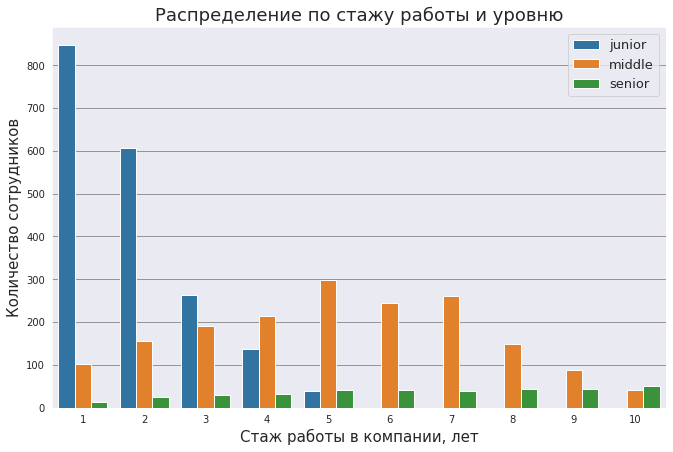

In [14]:
custom_countplot(
    train_data,
    num_col_1[0],
    'level',
    'по стажу работы и уровню',
    'Стаж работы в компании, лет' 
)

1. Признак представляет собой дискретную величину.
2. Больше всего сотрудников работает в компании **1-2 года**. Их количество заметно выбивается из остальных. И причём подавляющее большинство это _junior_-специалисты.
5. С увеличением срока сотрудничества число сотрудников снижается.

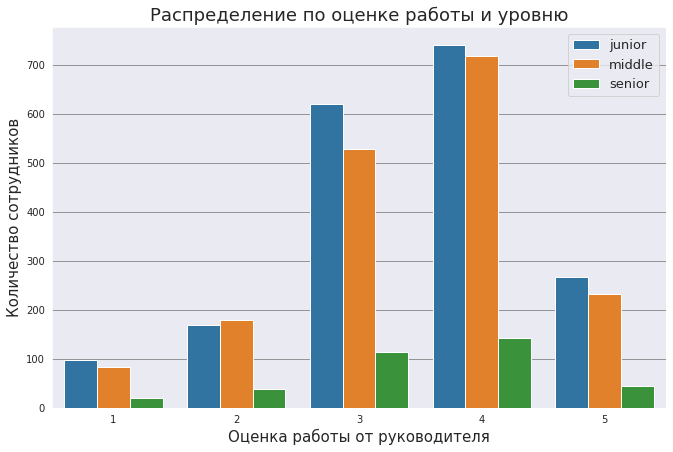

In [15]:
custom_countplot(
    train_data,
    num_col_1[1],
    'level',
    'по оценке работы и уровню',
    'Оценка работы от руководителя' 
)

1. Признак представляет собой дискретную величину.
2. Больше всего сотрудников получили от руководителя оценку **4** балла. На втором месте **3 балла**.
3. У _middle_-сотрудников больше двоек, чем у _junior_.

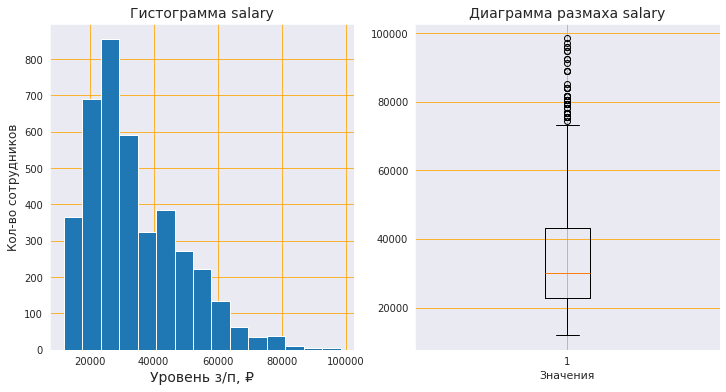

In [16]:
num_col_analyse(
    train_data,
    num_col_1[2],
    'Уровень з/п, ₽',
    bins=15
)

1. Чаще всего сотрудники получают около **30_000 рублей**. Оно же и является медианным.
2. Чем выше з/п, тем меньше таких сотрудников. Ожидаемо.
3. Есть значения-выбросы выше **74 тысяч рублей**.

Посмотрим на объекты с такими значениями:

In [17]:
# Вывод общей информации:
display(train_data[train_data['salary'] > 74_000].head())

print('\n\nКол-во сотрудников с з/п выше 74_000:',
      train_data[train_data['salary'] > 74_000]['id'].count())
print('Их должности:',
      train_data[train_data['salary'] > 74_000]['level'].unique())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
45,538347,technology,senior,high,3,no,no,1,84000,0.21
141,128304,marketing,senior,high,7,no,no,3,80400,0.48
196,486576,marketing,senior,high,9,no,no,4,76800,0.66
360,405345,marketing,senior,high,7,no,no,2,81600,0.58
427,399126,sales,senior,high,2,no,no,2,76800,0.26




Кол-во сотрудников с з/п выше 74_000: 60
Их должности: ['senior']


Удалять такие объекты не будем, чтобы не терять ценные данные для обучения.

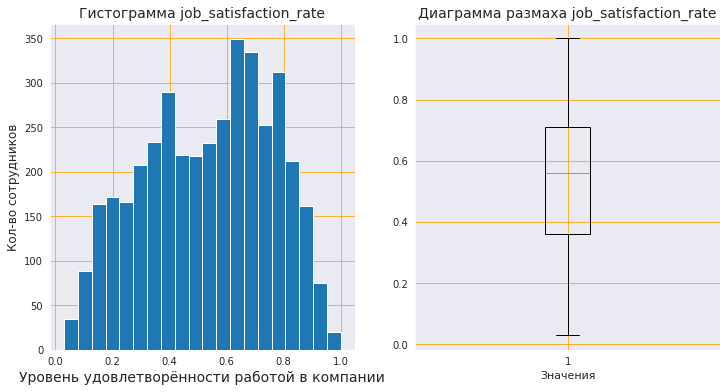

In [18]:
num_col_analyse(
    train_data,
    num_col_1[3],
    'Уровень удовлетворённости работой в компании',
    bins=20
)

1. Больше всего сотрудников имеет степень удовлетворённости **от 0.61 до 0.7**. Так же есть всплески на отметках **0.76-0.8** и **0.4**.
2. Медианная удовлетворённость — **0.56**.
3. Выбросов нет.

##### Категориальные признаки

Также напишем функцию _круговой диаграммы_ для удобства:

In [19]:
# Круговая диаграмма для кат. признаков:
def cat_col_analyse(df, column, figsize=(7, 7)):
    
    # Группировка по нужному признаку:
    column_grouped = df.pivot_table(
        index=column,
        values='id',
        aggfunc='count'
    )
    
    # Построение диаграммы:
    diagram = column_grouped.plot(
    kind='pie',
    y='id',
    figsize=figsize,
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2')
    )
    
    plt.title('Процентное соотношение ' + str(column))
    plt.ylabel('')
    plt.legend(loc=1)
    
    return plt.show(diagram)

Приступаем:

In [20]:
# Получим список категориальных признаков:
cat_col_1 = get_cat_col(train_data)

# Вывод общей информации:
print('Категориальные признаки трен. датасета train_data:',
     cat_col_1)
print('Их количество:', len(cat_col_1))

Категориальные признаки трен. датасета train_data: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Их количество: 5


В `train_data` больше категориальных признаков, чем количественных. Рассмотрим каждый признак подробнее:

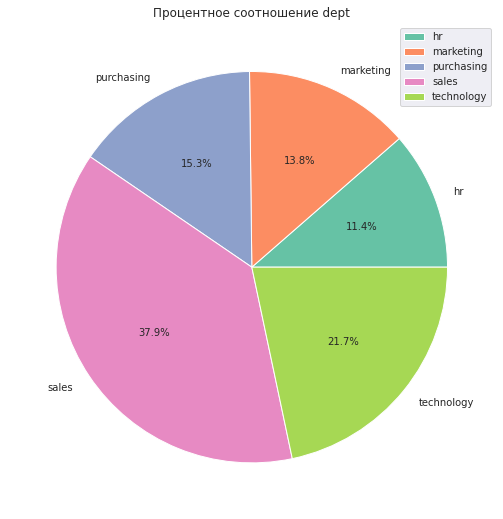

In [21]:
cat_col_analyse(
    train_data,
    cat_col_1[0],
    figsize=(9, 9)
)

1. Большинство сотрудников из выборки работает в _отделе продаж_ (**37.9%**).
2. Затем по количеству сотрудников идёт _технологический отдел_ (**21.7%**).
3. Меньше всего сотрудников в _HR отделе_ (**11.4%**).

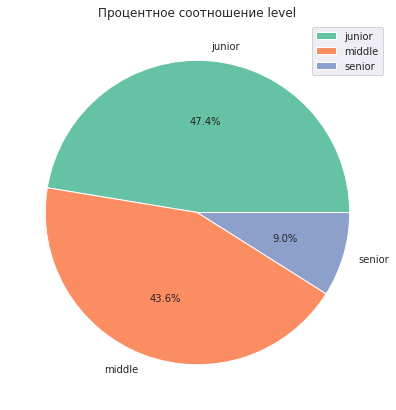

In [22]:
cat_col_analyse(
    train_data,
    cat_col_1[1]
)

1. Больше всего в компании задействовано _junior_-специалистов (**47.4%**).
2. За ними идут _middle_-специалисты с небольшим отставанием (**43.6%**).
3. Меньше всего, как и ожидается, специалистов класса _senior_ (**9%**).

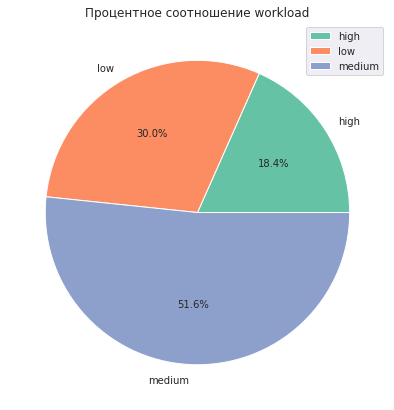

In [23]:
cat_col_analyse(
    train_data,
    cat_col_1[2]
)

1. Абсолютное большинство сотрудников обладает _средним_ уровнем нагрузки (**51.6%**).
2. Меньшинство — _высоким_ (**18.4%**).

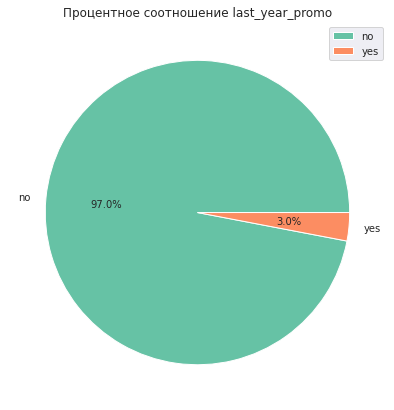

In [24]:
cat_col_analyse(
    train_data,
    cat_col_1[3]
)

_Только **3%** сотрудников получили повышение за последний год_.

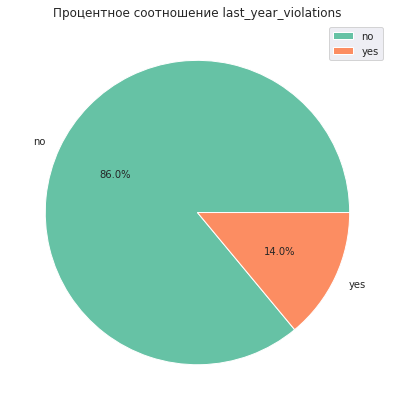

In [25]:
cat_col_analyse(
    train_data,
    cat_col_1[4]
)

_**14%** сотрудников из предоставленной выборки нарушали трудовой договор за последний год_.


#### Тестовая выборка

Теперь проведём исследовательский анализ данных для тестовой выборки `test_features`. Начнём с количественных признаков.

##### Количественные признаки

Будем работать по аналогии с тренировочным датасетом:

In [26]:
# Получим список количественных признаков:
num_col_test = get_num_col(test_features.drop('id', axis=1))

# Вывод общей информации:
print('Количественные признаки тест. датасета test_features:',
     num_col_test)
print('Их количество:', len(num_col_test))

Количественные признаки тест. датасета test_features: ['employment_years', 'supervisor_evaluation', 'salary']
Их количество: 3


Два дискретных признака `employment_years` и `supervisor_evaluation` на месте. Здесь же и непрерывный `salary`.

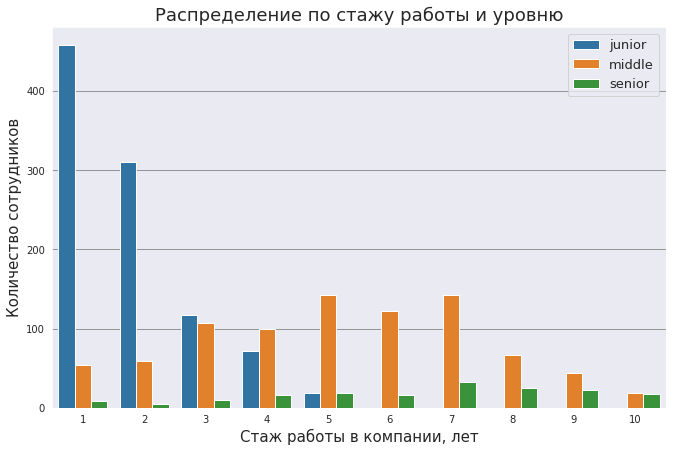

In [27]:
custom_countplot(
    test_features,
    num_col_test[0],
    'level',
    'по стажу работы и уровню',
    'Стаж работы в компании, лет' 
)

Ситуация идентичная.

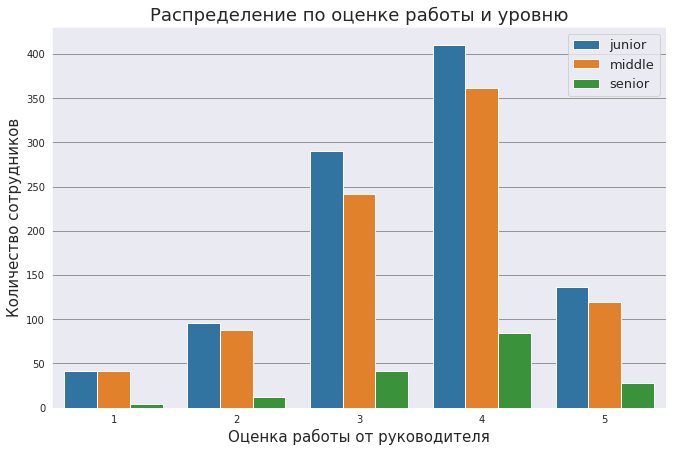

In [28]:
custom_countplot(
    test_features,
    num_col_test[1],
    'level',
    'по оценке работы и уровню',
    'Оценка работы от руководителя' 
)

В тестовой выборке по всем оценкам, кроме 1, держимт лидерство уровень _junior_.

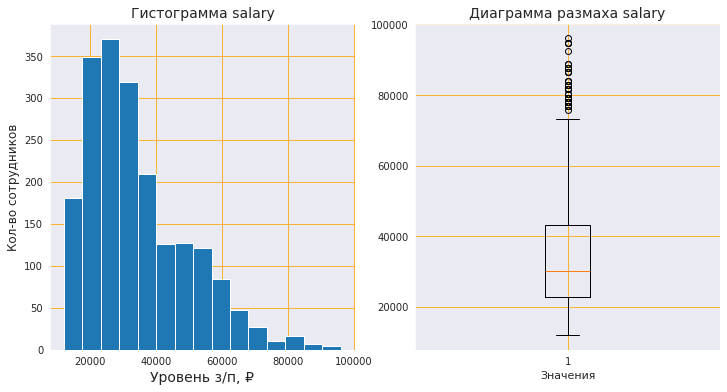

In [29]:
num_col_analyse(
    test_features,
    num_col_test[2],
    'Уровень з/п, ₽',
    bins=15
)

Ситуация очень схожа с тренировочной выборкой.

##### Категориальные признаки

In [30]:
# Получим список категориальных признаков:
cat_col_test = get_cat_col(test_features)

# Вывод общей информации:
print('Категориальные признаки тест. датасета test_features:',
     cat_col_test)
print('Их количество:', len(cat_col_test))

Категориальные признаки тест. датасета test_features: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Их количество: 5


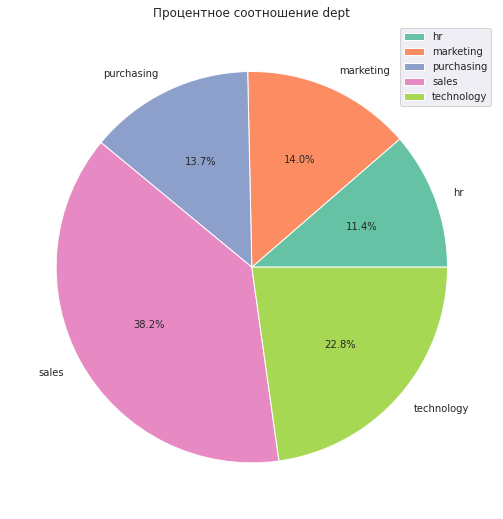

In [31]:
cat_col_analyse(
    test_features,
    cat_col_test[0],
    figsize=(9, 9)
)

В тестовой выборке чуть больше представлены отделы _маркетинга_ и _технологический_.

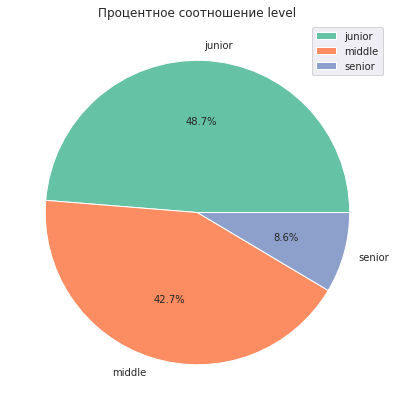

In [32]:
cat_col_analyse(
    test_features,
    cat_col_test[1]
)

Ситуация аналогична тренировочной выборке.

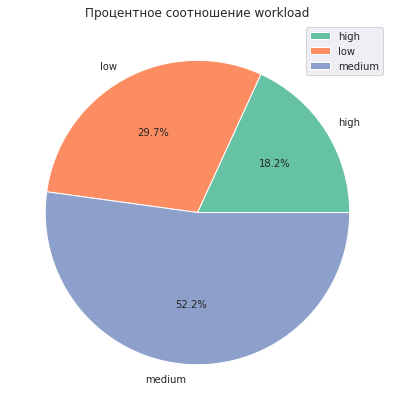

In [33]:
cat_col_analyse(
    test_features,
    cat_col_test[2]
)

Ситуация идентична тренировочной выборке.

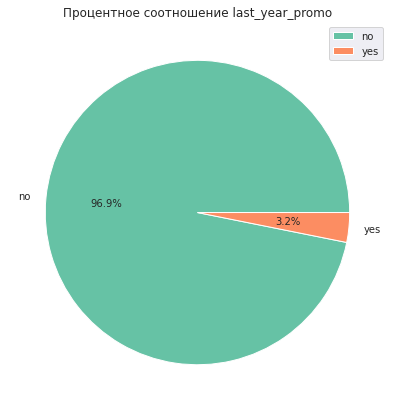

In [34]:
cat_col_analyse(
    test_features,
    cat_col_test[3]
)

Ситуация так же аналогична тестовой выборке.

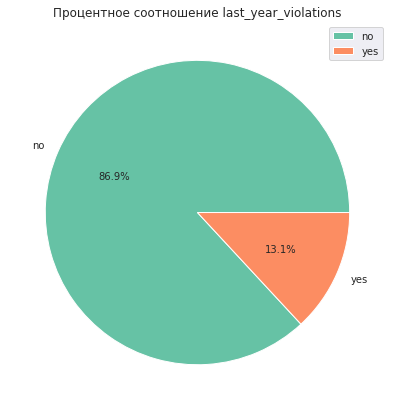

In [35]:
cat_col_analyse(
    test_features,
    cat_col_test[4]
)

Почти на процент меньше объектов из тех, кто нарушал ТД по сравнению с тренировочными данными.

#### Итоги

Выделим основные моменты _исследовательского анализа данных_:
1. Чаще всего сотрудники получают около **30_000 рублей**.
2. Больше всего сотрудников работает в компании **1-2 года**.
3. Больше всего сотрудников имеет степень удовлетворённости **от 0.61 до 0.7**.
4. Больше всего в компании задействовано _junior_-специалистов (**47.4%**).
5. Большинство сотрудников из выборки работает в _отделе продаж_ (**37.9%**).
6. **Только 3% сотрудников получили повышение за последний год.**
7. Тренировочные и тестовые данные не имеют существенных различий.

Перейдём к этапу корреляционного анализа данных. Проверим признаки на мультиколлинеарность, чтобы не было дальнейших проблем с обучением модели.

### Корреляционный анализ данных

#### Тренировочная выборка

Перед началом анализа напишем функцию для его упрощения.

In [36]:
# Функция для визуализации матрицы корреляции:
# На входе подаём датасет и непрерывные числовые признаки.
def correlation_matrix(data, interval_cols):

    # Формирование матрицы корреляции:
    phik_overview = phik_matrix(data.drop('id', axis=1), interval_cols=interval_cols)

    return plot_correlation_matrix(
            phik_overview.values,
            x_labels=phik_overview.columns,
            y_labels=phik_overview.index,
            vmin=0, vmax=1, color_map='Greens',
            title=(r'Матрица корреляции $\phi_K$'),
            fontsize_factor=1.5,
            figsize=(20, 15)
            )

Приступим:

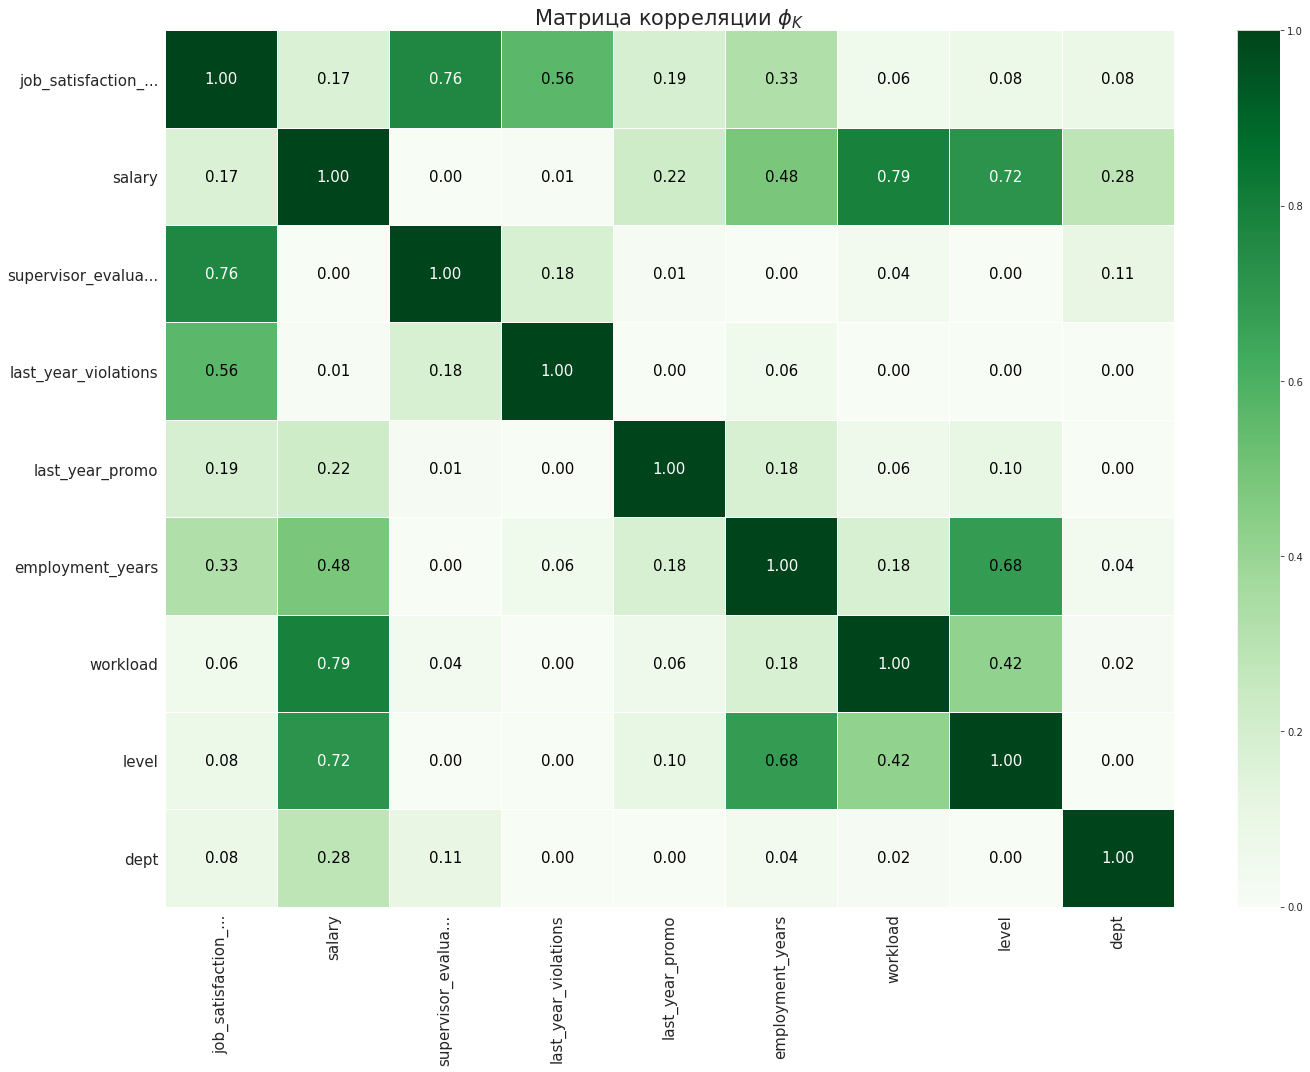

In [37]:
# Построение визуализации:
correlation_matrix(
    train_data,
    ['salary', 'job_satisfaction_rate']
)

Оценка будет дана в промежуточном выводе.

#### Тестовая выборка

Построим матрицу корреляции для тестовых данных:

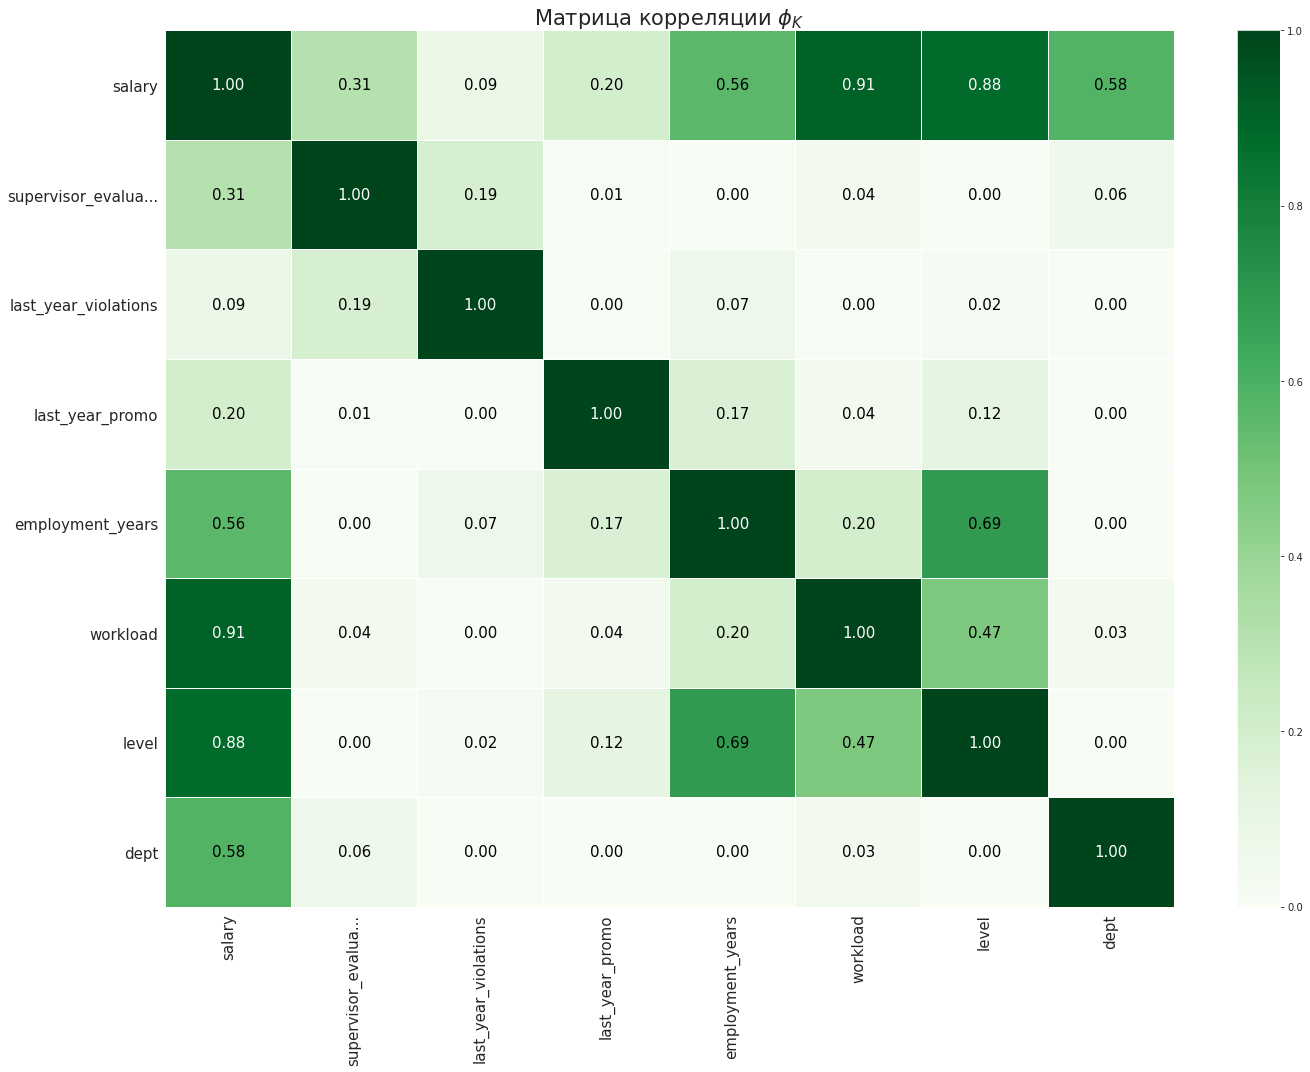

In [38]:
# Построение визуализации:
correlation_matrix(
    test_features,
    'salary'
)

Интересно. В тестовых уже появляется мультиколлинеарность, однако удалять ничего не будем, так как это тестовые данные, которые имитируют реальный поток данных.

#### Итоги

Для оценки тесноты связи воспользуемся _шкалой Чеддока_.

C **целевым** признаком корреляцию имеют следующие входные признаки:
- `supervisor_evaluation` имеет _высокую_ корреляцию;
- `last_year_violations` имеет _заметную_ корреляцию;
- `employment_years` имеет _умеренную_ корреляцию;
- у остальных корреляция _слабая_;

Так же признак `salary` имеет _высокую_ корреляцию с признаками `workload` и `level`. А признак `level` в свою очередь _заметно_ коррелирует с `employment_years` и _умеренно_ с `workload`.

В тренировочных данных **мультиколлинеарности не наблюдается**.

### Подготовка данных

Перед началом подготовки данных определимся со способом подготовки.

1. Эти признаки закодируем с помощью _OrdinalEncoder_: `level`, `workload`. Так как их можно представить как _ранговые категории_.

2. Эти признаки закодируем с помощью _OneHotEncoder_: `dept`, `last_year_promo`, `last_year_violations`. Параметру `drop` передадим значение _first_, чтобы избежать избыточных переменных.

3. Эти признаки (количественные) будем _масштабировать_: `salary`.

4. Пропущенные значения будем обрабатывать с помощью _SimpleImputer_.

Все эти пункты будут являться частью этапа подготовки данных в нашем пайплайне.

Обозначим эти признаки в отдельных переменных для пайплайна и обозначим выборки:

In [39]:
# Разделим признаки по способам кодирования:
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']

ord_col = ['level', 'workload']

In [40]:
num_col = ['salary']

# Обозначим отдельно целевой признак:
target_1 = 'job_satisfaction_rate'

Перед тем, как получить выборки для обучения и тестирования моделей, проверим наличие явных дубликатов без участия столбца `id`. Он не участвует в обучении и с его отсутствием в датасете могут образоваться явные дубликаты, которые ухудшат качество обучения модели.

In [41]:
# Перенос id объектов в индексы:
train_data = train_data.set_index('id')

# Проверка на явные дубликаты:
print('Кол-во явных дубликатов без id:', train_data.duplicated().sum())

Кол-во явных дубликатов без id: 245


Уберём явные дубликаты для повышения качества дальнейшего обучения модели:

In [42]:
train_data.drop_duplicates(inplace=True)

# Проверка:
print(f'Теперь в тренировочных данных {train_data.shape[0]} строк.')

Теперь в тренировочных данных 3755 строк.


Восстановим индексацию и вернём столбец `id`.

In [43]:
# Восстановим индексацию:
train_data['id'] = train_data.index
train_data.reset_index(drop=True, inplace=True)

# Проверка:
train_data.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,id
0,sales,junior,medium,2,no,no,1,24000,0.58,155278
1,hr,junior,high,2,no,no,5,38400,0.76,653870
2,sales,junior,low,1,no,no,2,12000,0.11,184592
3,technology,junior,low,4,no,no,2,18000,0.37,171431
4,hr,junior,medium,1,no,no,3,22800,0.20,693419


In [44]:
X_train = train_data.drop(['id', target_1], axis=1)
y_train = train_data[target_1]

X_test = test_features.drop('id', axis=1)
y_test = test_target[target_1]

# Проверка размерностей:
print('Размерность X_train:', X_train.shape)
print('Размерность y_train:', y_train.shape)
print('\nРазмерность X_test:', X_test.shape)
print('Размерность y_test:', y_test.shape)

Размерность X_train: (3755, 8)
Размерность y_train: (3755,)

Размерность X_test: (2000, 8)
Размерность y_test: (2000,)


Выборки получили. Определимся, какие модели будем использовать.

Перед нами стоит задача **регрессии**, поэтому будем использовать две модели для решения такой задачи: 
- Модель лин. рег. _LinearRegression_;
- Модель дерева решений _DecisionTreeRegressor_.

Соберём пайплайн.

In [45]:
# Шаг 1: OHE-кодирование
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)


# Шаг 2: OrdinalEncoder
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord', 
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# Объединение подготовок кат. и кол. признаков
# в общий шаг подготовки данных:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col),
    ], 
    remainder='passthrough'
)

# Итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

Также будем подберать гиперпараметры как минимум для одной модели. Из-за обилия параметров это будет **Decision Tree**. Диапазон для подбора возьмём пошире, поэтому будем воспользуемся _RandomizedSearchCV_ для подбора.

Создадим словарь (список словарей) гиперпараметров (ГП), в которые войдут модели, гиперпараметры модели и методы кодирования. Его мы передадим инструменту для подбора.

In [46]:
param_rs = [
      
    # Словарь для модели Decision Tree и её ГП:  
    {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     
     'models__max_depth': range(1, 21),
     'models__min_samples_split': range(2, 21),
     'models__min_samples_leaf': range(1, 16),
     
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']},
     
    
    # Словарь для модели лин.рег.:
    {'models': [LinearRegression()],
    
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']}
    
]

#### Метрика

Перед тем, как запускать подбор, необходимо задать метрику, на которую подбор будет ориентироваться при вычислении лучшей модели. Создадим новую метрику — **sMAPE** («симметричное среднее абсолютное процентное отклонение»), на которую будем ориентироваться. Напишем свою функцию, которую вскоре передадим функции _make_scorer_ для создания своей метрики:

In [47]:
# Функция для расчёта метрики:
def smape_func(y_test, y_pred):
    metric = np.sum(np.abs(y_test - y_pred) / ((np.abs(y_test) + np.abs(y_pred)) / 2)) * (100 / len(y_test))
    return metric

# Cоздаём пользовательскую метрику:
smape_score = make_scorer(smape_func, greater_is_better=False)

#### Получение лучшей модели

Передаём инструменту для подбора пайплайн, параметры для подбора и метрику.

In [48]:
rs_task_1 = RandomizedSearchCV(
    pipe_final,
    param_rs,
    scoring=smape_score,
    n_jobs=-1,
    cv=15,
    n_iter=30,
    random_state=RANDOM_STATE
)

simplefilter(action='ignore', category=Warning)

# Запуск подбора:
rs_task_1.fit(X_train, y_train)

# Вывод результатов:
print('Лучшая модель и её параметры:\n\n', rs_task_1.best_params_)
print('\n\nМетрика sMAPE лучшей модели на кросс-валидации:',
      abs(rs_task_1.best_score_.round(2)))

Лучшая модель и её параметры:

 {'preprocessor__num': 'passthrough', 'models__min_samples_split': 11, 'models__min_samples_leaf': 3, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=42)}


Метрика sMAPE лучшей модели на кросс-валидации: 15.16


Таким образом, лучшей себя показала модель **DecisionTreeRegressor** с такими ГП:
- _Макс. глубиной_ (уровнями с лог. условиями) _`17`_;
- _Кол-вом объектов в одном листе `3`_;
- _Кол-вом объектов в листе для разделения на классы `11`_;
- C _пропущенным_ этапом масштабирования указанных числовых признаков;

Проверим эту модель на тестовых данных. Модель будет успешной при значении метрики **SMAPE ≤ 15**.

In [49]:
# Выделим лучшую модель:
model_reg = rs_task_1.best_estimator_

# Получение предсказаний:
y_pred = model_reg.predict(X_test)

# Вывод результата:
print('Метрика sMAPE лучшей модели на тестовой выборке:',
      round(smape_func(y_test, y_pred), 2))

Метрика sMAPE лучшей модели на тестовой выборке: 13.5


Отлично, мы получили успешную модель. Самое время проверить её на адекватность.

#### Проверка на адекватность

Инициализируем дамми-модель, получим от неё предсказания и сравним метрики:

In [50]:
# Инициализация модели:
dummy_regressor = DummyRegressor()

# Обучение модели:
dummy_regressor.fit(X_train, y_train)

# Получение предсказаний:
dummy_pred = dummy_regressor.predict(X_test)

# Получение метрики:
print('Метрика sMAPE дамми-модели на тестовой выборке:',
      round(smape_func(y_test, dummy_pred), 2))

Метрика sMAPE дамми-модели на тестовой выборке: 38.26


Отлично, наша модель прошла проверку на адекватность, ведь показатель метрики **sMAPE** у дамми-модели больше в более чем в два раза. 

Таким образом, модель показала себя успешной при решении задачи **регрессии**. Сохраним результаты работы в датасет для удобства:

In [51]:
# Сохранение в датасет:
task_1_results = pd.DataFrame(rs_task_1.cv_results_).sort_values(by='rank_test_score')

# Вывод топ-5 опробованных моделей:
display(task_1_results.head())

print(f'\nВсего было опробовано {task_1_results.shape[0]} обученных моделей.')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth,param_models,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
27,0.027872,0.002810,0.010367,0.000642,passthrough,11,3,17,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",...,-16.302966,-15.373621,-17.124773,-12.886338,-15.755846,-14.674886,-14.653256,-15.158380,1.092362,1
23,0.030733,0.004052,0.012009,0.001874,MinMaxScaler(),4,6,18,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",...,-16.827256,-15.154227,-16.957415,-14.074328,-16.058871,-14.756233,-13.998607,-15.172547,1.000922,2
22,0.026721,0.002935,0.010860,0.002042,passthrough,11,6,19,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",...,-16.827256,-15.154227,-16.995882,-14.074328,-16.058871,-14.756233,-14.280970,-15.190071,0.987445,3
6,0.029941,0.003831,0.012156,0.002247,RobustScaler(),2,7,20,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': RobustScaler(), 'models_...",...,-17.239233,-15.173673,-17.491197,-14.831802,-15.616988,-14.273489,-14.656670,-15.226104,1.081203,4
21,0.028789,0.002617,0.012076,0.002245,StandardScaler(),5,7,16,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",...,-17.239233,-15.163826,-17.444983,-14.831802,-15.616988,-14.259117,-14.687870,-15.233673,1.067553,5



Всего было опробовано 30 обученных моделей.


#### Итоги

Мы получили лучшую модель **DecisionTreeRegressor** с такими ГП:
- _Макс. глубиной_ (уровнями с лог. условиями) _`17`_;
- _Кол-вом объектов в одном листе `3`_;
- _Кол-вом объектов в листе для разделения на классы `11`_;
- C _пропущенным_ этапом масштабирования указанных числовых признаков;

_Значение метрики **SMAPE** у полученной модели `13.5`_.

В пятёрке лучших оказались только DecisionTreeRegressor'ы с различиями только в способе масштабирования (или его отсутствии) и наборами гиперпараметров.

### Оформление выводов

Осталось интерпретировать нашу лучшую модель. Покажем, на что она ориентировалась при расчёте предсказанных значений и что сильнее влияло на это. Для этого воспользуемся методом **SHAP**.

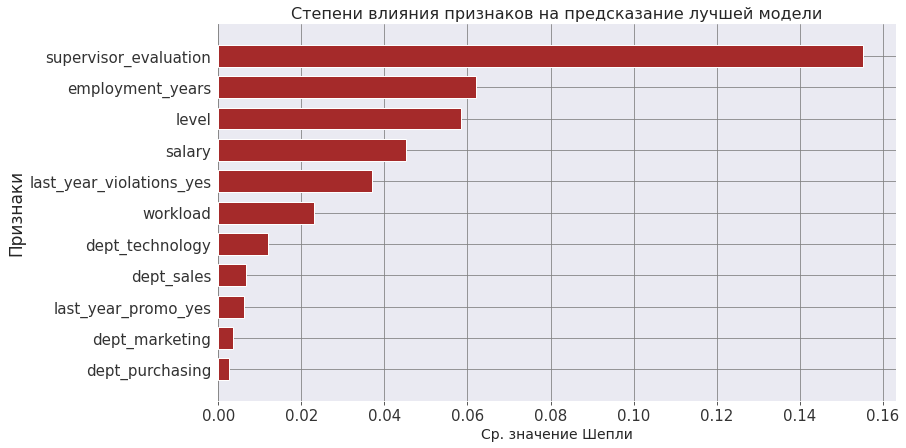

In [52]:
# Извлекаем из этапа пайплайна способы подготовки данных:
preprocessor = model_reg.named_steps['preprocessor']


# Преобразование признаков трен. выборки:
X_train_transformed = preprocessor.fit_transform(X_train)


# Объявление эксплейнера:
explainer = shap.TreeExplainer(model_reg.named_steps['models'], X_train_transformed)


# Преобразование признаков тест. выборки:
X_test_transformed = preprocessor.transform(X_test)

# Получим названия признаков:
feature_names = preprocessor.get_feature_names_out()

# Формируем преобразованный тестовый датафрейм:
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)



# Объявляем shap_values:
shap_values = explainer(X_test_transformed)


# Уберём префиксы в именах признаков:
feature_names = [name.split("__")[-1] for name in feature_names]

# Построение графика важности признаков:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    plot_type='bar',
    feature_names=feature_names,
    plot_size=[12,6],
    color='brown',
    show=False
)

# Настройка графика:
fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=10)
ax.set_xlabel('Ср. значение Шепли', fontsize=14)
ax.set_title(
    'Степени влияния признаков на предсказание лучшей модели',
    fontsize=16
)

cb_ax = fig.axes[0] 

cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Признаки", fontsize=17)

plt.show()

Таким образом, сильнее всего влияет на _целевой признак_ **оценка качества работы сотрудника, которую дал руководитель**. Она является абсолютным лидером по влиянию на предсказания модели.

Рассмотрим подробнее, как именно значения признаков влияют на предсказания:

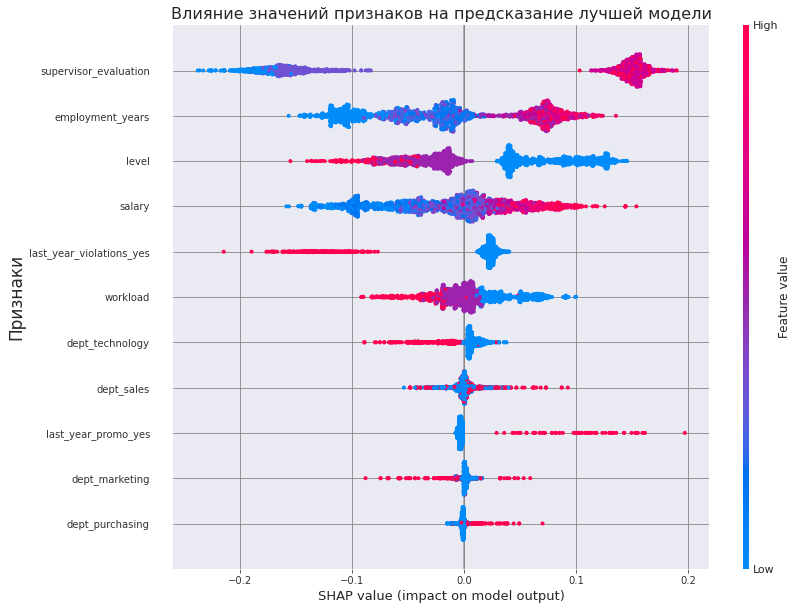

In [53]:
# Создание нового объекта Explanation с feature_names:
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=shap_values.base_values,
    data=X_test_transformed,
    feature_names=feature_names
)

# Построение графика:
shap.plots.beeswarm(
    shap_explanation,
    max_display=20,
    plot_size=(12, 10),
    show=False
)

# Настройка графика:
fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_title(
    'Влияние значений признаков на предсказание лучшей модели',
    fontsize=16
)

cb_ax = fig.axes[0] 

cb_ax.tick_params(labelsize=10)
cb_ax.set_ylabel("Признаки", fontsize=17)

plt.show()

Признаки здесь также отсортированы по убыванию значимости сверху вниз. Негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет предсказание модели к меньшему значению. Положительные же наоборот к бо́льшему. 

Из графика видно, что:

1. Чем _ниже_ значение признака `supervisor_evaluation`, тем выше вероятность, что **целевой признак** будет _занижен_.


2. То же самое можно сказать и про `employment_years`. Чем дольше работает сотрудник, тем выше вероятность предсказанного значения (удовлетворённости работой) в бо́льшую сторону.


3. Что примечательно, уровень сотрудника `level` хоть и не оказывает такого сильного влияния на предсказанное значение, но всё же чем выше уровень сотрудника, тем выше вероятность предсказанной удовлетворённости работой в _меньшую_ сторорону. Выглядит вполне логично, для многих junior-сотрудников это может быть первая компания и им не с чем сравнивать.

4. С зарплатой `salary` всё логично, чем она ниже, тем ниже будет предсказанное значение удовлетворённости. Влияние этого признака невелико.

5. С нарушениями трудового договора `last_year_violations` тоже всё логично. Если факт нарушения присутствует, то, скорее всего, удовлетворённость работой в компании будет ниже.

Можно переходить к решению задачи 2.

## **Задача 2**. Классификация

### Ознакомление с данными

В этой задаче будем взаимодействовать с другими датасетами: тренировочным `train_quit` и тестовым `test_target_quit`. Cохраним их и проверим корректность считывания:

In [54]:
# Прочитаем и сохраним полученные датасеты:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

# Проверка считывания:
print('Датасет train_quit:')
display(train_quit.head(3))

print('\n\nДатасет test_target_quit:')
display(test_target_quit.head(3))

Датасет train_quit:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no




Датасет test_target_quit:


,id,quit
0,999029,yes
1,372846,no
2,726767,no


Данные считаны корректно и сохранены. Наименования столбцов приведены к стандарту PEP8. Содержание данных соответствует заявленному.

Тестовые входные признаки здесь такие же, как и в первой задаче (датасет `test_features`). Поэтому его на этом этапе смотреть не будем. Рассмотрим общую информацию о даатсетах, посмотрим на наличие **явных** дубликатов, пропусков, типов данных.

In [55]:
# Создадим для удобства список датасетов:
df_list = [train_quit, test_target_quit]

# Вывод общей информации:
for df in df_list:
    display(df.info())
    print(f'Кол-во строк: {df.shape[0]}, кол-во столбцов: {df.shape[1]}')
    print(f'Кол-во явных дубликатов: {df.duplicated().sum()}\n\n\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

Кол-во строк: 4000, кол-во столбцов: 10
Кол-во явных дубликатов: 0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

Кол-во строк: 2000, кол-во столбцов: 2
Кол-во явных дубликатов: 0






Пропусков и **явных** дубликатов не обнаружено. Типы данных у столбцов вопросов не вызывают. Таким образом:

#### Итоги

1. Данные были считаны корректно и сохранены в переменные.
2. Содержание данных соответствует заявленному.

Переходим к следующему этапу.

### Предобработка данных

Изучим данные и по необходимости избавимся от некорректных значений.

In [56]:
print('Перечень значений кат. столбцов train_quit:\n')
for column in get_cat_col(train_quit):
    print(f'Уникальные значения {column}: {train_quit[column].unique()}')

Перечень значений кат. столбцов train_quit:

Уникальные значения dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения level: ['middle' 'junior' 'sinior']
Уникальные значения workload: ['high' 'medium' 'low']
Уникальные значения last_year_promo: ['no' 'yes']
Уникальные значения last_year_violations: ['no' 'yes']
Уникальные значения quit: ['no' 'yes']


Исправим ошибку в столбце `level`:

In [57]:
# Исправим опечатку:
train_quit['level'].replace('sinior', 'senior', inplace=True)

# Проверка:
print('Уникальные значения level:', train_quit['level'].unique())

Уникальные значения level: ['middle' 'junior' 'senior']


В остальном некорректных значений не обнаружено. Перед нами стоит задача **бинарной классификации**. В прошлой задаче была проблема несоответствия `id` у тестовых датасетов. Посмотрим, как здесь:

In [58]:
# Проверка соответствия:
display(test_features.head(), test_target_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Здесь такая же проблема. Исправим это через объединение/разделение:

In [59]:
print('Размерность test_features до обработки:', test_features.shape)
print('Размерность test_target_quit до обработки:', test_target_quit.shape)

# Объединим:
common_test = test_features.merge(test_target_quit, on='id', how='left')
# Разделим вновь:
test_features = common_test.drop('quit', axis=1)
test_target_quit = common_test[['id', 'quit']]

# Проверка:
print('\nРазмерность test_features после обработки:', test_features.shape)
print('Размерность test_target после обработки:', test_target_quit.shape)
display(test_features.head())
display(test_target_quit.head())

Размерность test_features до обработки: (2000, 9)
Размерность test_target_quit до обработки: (2000, 2)

Размерность test_features после обработки: (2000, 9)
Размерность test_target после обработки: (2000, 2)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,485046,no
1,686555,no
2,467458,no
3,418655,no
4,789145,no


Порядок наблюдений в тестовых датасетах восстановлен.

#### Итоги

1. Некорректных значений не обнаружено.
2. Устранена опечатка в столбце `level`.
3. Восстановлен порядок наблюдений в тестовых датасетах.

Переходим к следующему этапу.

### Исследовательский анализ данных

#### Количественные признаки

Теперь отдельно проанализируем количествоенные и категориальные признаки тренировочного датасета `train_quit`. Начнём с количественных. Функции уже есть.

In [60]:
# Отбор количественных признаков:
num_col_2 = get_num_col(train_quit.drop('id', axis=1))

# Вывод общей информации:
print('Количественные признаки трен. датасета train_quit:',
     num_col_2)
print('Их количество:', len(num_col_2))

Количественные признаки трен. датасета train_quit: ['employment_years', 'supervisor_evaluation', 'salary']
Их количество: 3


Рассмотрим числовые характеристики количественных признаков:

In [61]:
train_quit.drop('id', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.70150,2.541852,1.0,2.0,3.0,6.0,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0


Ничего нового здесь не видим. Всё совпадает с выводами, которые мы сделали на прошлой задаче.

1. Среднее время работы в компании для полученной выборки — **около 3-х лет**.
2. Есть «старожилы», работающие в компании **10 лет**.
3. Средняя оценка кач-ва работы от руководителя в выборке — **3.5 баллов**.
4. Медианная заработная плата сотрудников выборки — **30 тысяч рублей**. Есть и минимальный уровень з/п в **12 тысяч рублей**. Похоже, это стажёры. Снова есть _значение-«выброс»_ в **96_400** р. Скорее всего, зарплаты senior-специалистов.

Рассмотрим каждый признак подробнее с помощью ранее написанных функций:

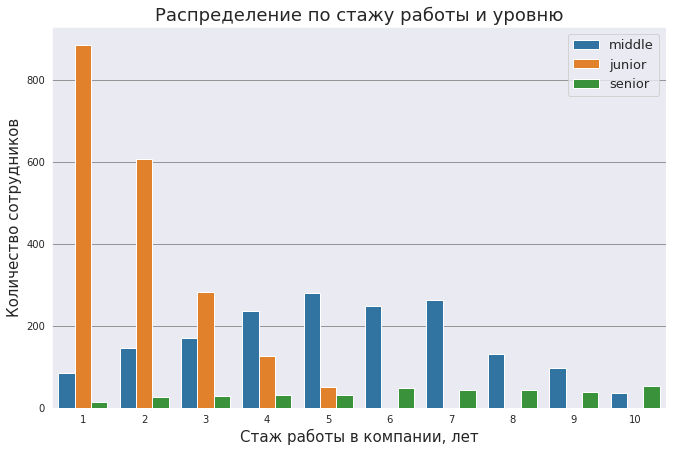

In [62]:
custom_countplot(
    train_quit,
    num_col_2[0],
    'level',
    'по стажу работы и уровню',
    'Стаж работы в компании, лет'
)

Ситуация аналогичная с предыдущими тестовыми данными. Стажем до трёх лет в компании больше всего отмечены джуны.

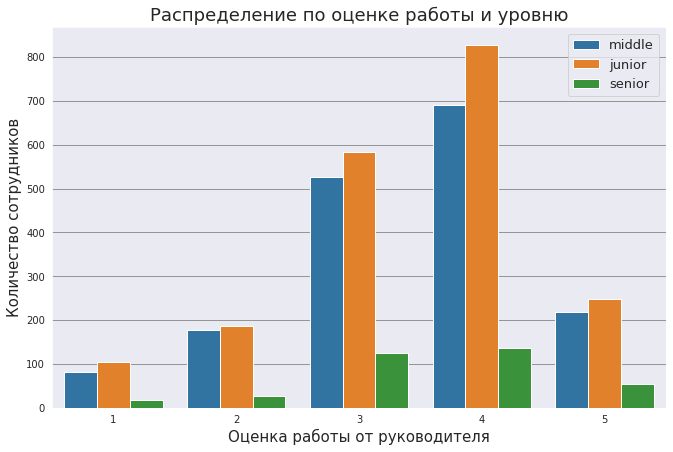

In [63]:
custom_countplot(
    train_quit,
    num_col_2[1],
    'level',
    'по оценке работы и уровню',
    'Оценка работы от руководителя'
)

Здесь уже нет лидерства мидлов в двойках, как в первом тренировочном датасете.

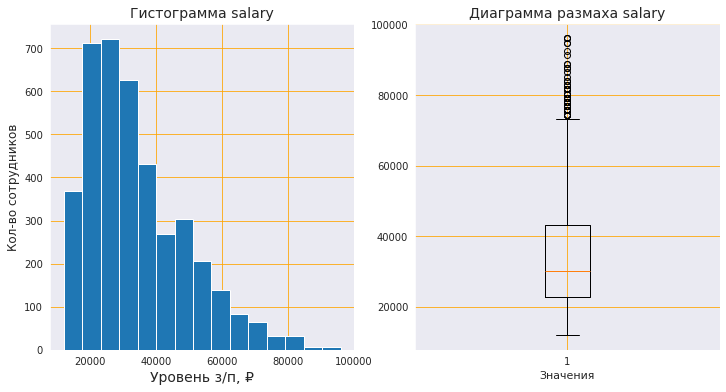

In [64]:
num_col_analyse(
    train_quit,
    num_col_2[2],
    'Уровень з/п, ₽',
    bins=15
)

Чем выше з/п, тем меньше таких сотрудников. Всё как обычно.
Есть и значения-выбросы выше **74 тысяч рублей**.

Посмотрим на объекты с такими значениями:

In [65]:
# Вывод общей информации:
display(train_quit[train_quit['salary'] > 74_000].head())

print('\n\nКол-во сотрудников с з/п выше 74_000:',
      train_quit[train_quit['salary'] > 74_000]['id'].count())
print('Их должности:',
      train_quit[train_quit['salary'] > 74_000]['level'].unique())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
16,113657,technology,senior,high,5,yes,no,3,82800,no
100,540780,sales,senior,high,7,no,yes,3,78000,no
179,208223,technology,senior,high,7,no,no,3,94800,no
185,694599,technology,senior,high,1,no,no,4,96000,no
198,646839,sales,senior,high,5,no,no,4,79200,no




Кол-во сотрудников с з/п выше 74_000: 78
Их должности: ['senior']


В датасете `train_quit` представлено чуть больше сотрудников уровня _senior_ c з\п выше 74 тысяч рублей, что не может не радовать.

#### Категориальные признаки

С помощью уже написанной функции посмотрим на категориальные признаки:

In [66]:
# Отбор количественных признаков:
cat_col_2 = get_cat_col(train_quit)

# Вывод общей информации:
print('Категориальные признаки трен. датасета train_quit:',
     cat_col_2)
print('Их количество:', len(cat_col_2))

Категориальные признаки трен. датасета train_quit: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
Их количество: 6


В этом тренировочном датасете представлено больше категориальных признаков. Это ожидаемо, ведь целевой признак теперь категориальный.

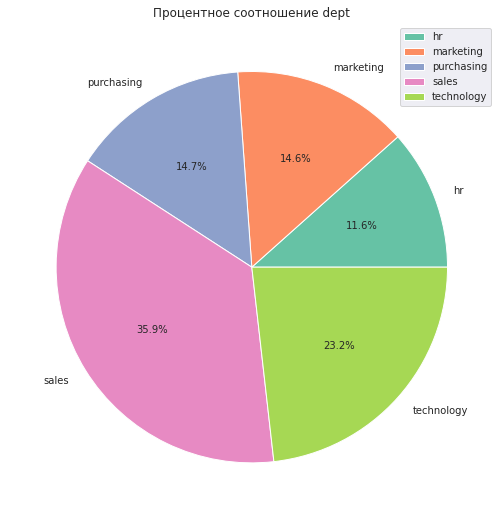

In [67]:
cat_col_analyse(
    train_quit,
    cat_col_2[0],
    figsize=(9, 9)
)

Как и в предыдущей задаче, лучше всего представлен _отдел продаж_ (**35.9%** от выборки).

На втором месте _технологический отдел_ (**23.2%** от выборки).

Отделы _закупок_ и _маркетинга_ представлены почти на равных (**14.7%** и **14.6%** соответственно).

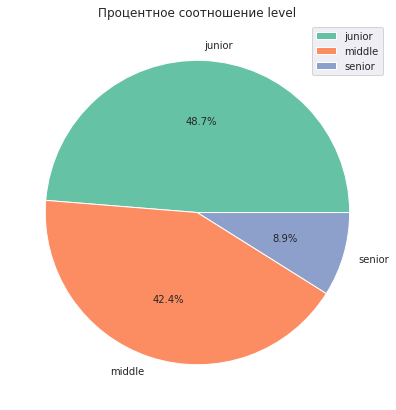

In [68]:
cat_col_analyse(
    train_quit,
    cat_col_2[1]
)

По факту чуть меньше представлено сотрудников уровня _senior_, чем в предыдущий раз. _Junior_ и _middle_ представлены побольше.

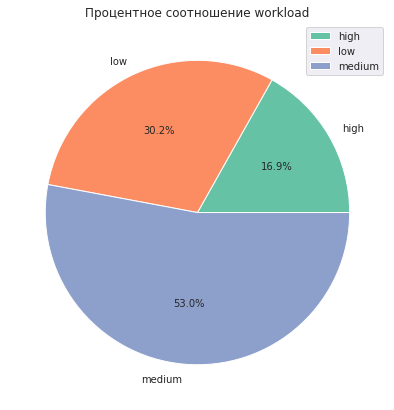

In [69]:
cat_col_analyse(
    train_quit,
    cat_col_2[2]
)

Здесь побольше сотруднков со _средней_ нагрузкой, чем в прошлый раз. Остальные примерно на том же уровне.

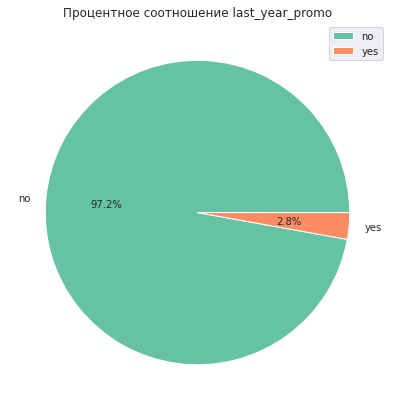

In [70]:
cat_col_analyse(
    train_quit,
    cat_col_2[3]
)

Всё так же очень мало сотрудников, получивших повышение. Только **2.8%**.

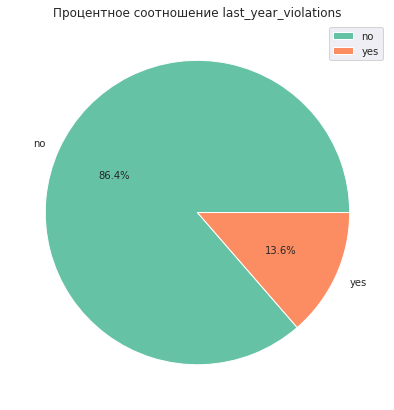

In [71]:
cat_col_analyse(
    train_quit,
    cat_col_2[4]
)

Картина та же по нарушениям трудового договора.

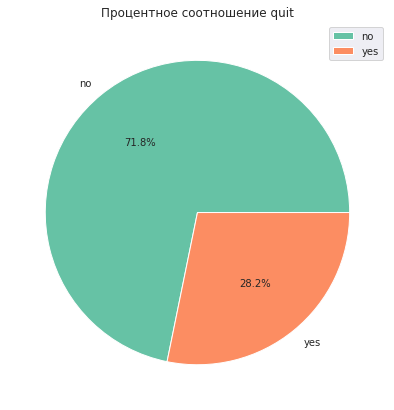

In [72]:
cat_col_analyse(
    train_quit,
    cat_col_2[5]
)

Уволившихся сотрудников в полученной выборке **28.2%** против **71.8%** оставшихся. Мы имеем дело с _**дисбалансом классов**_.



#### Портрет «уволившегося сотрудника»

Составим портрет «уволившегося сотрудника». Посмотрим, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности.

Для этого отфильтруем наблюдения по факту увольнения:

In [73]:
# Отбор уволившихся сотрудников:
quitted_emp = train_quit.query('quit == "yes"')

# Проверка:
quitted_emp.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


Нужные объекты отобраны. Рассмотрим подробнее.

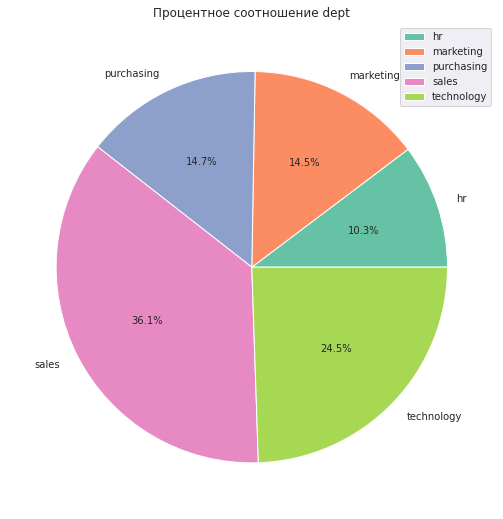

In [74]:
cat_col_analyse(
    quitted_emp,
    'dept',
    figsize=(9, 9)
)

Больше всего уволенных сотрудников из _отдела продаж_. Но в этом ничего удивительного нет, потому что этот отдел представлен в наибольшей мере. То же самое можно сказать и про другие отделы. Вывод: нет какого-то определённого отдела, откуда сотрудники "бегут".

Посмотрим по уровню загруженности:

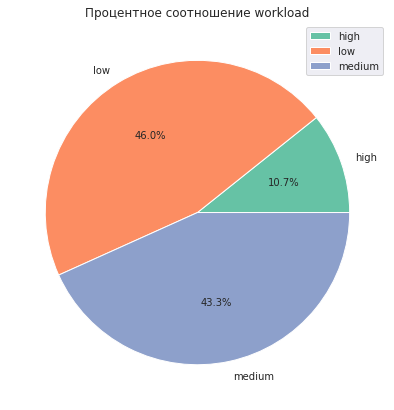

In [75]:
cat_col_analyse(
    quitted_emp,
    'workload'
)

Здесь уже поинтереснее: уволенный сотрудник чаще всего обладает _пониженной_ нагрузкой. В общей выборке таких сотрудников было **30%**, а здесь уже **46%**. Посмотрим, из каких они отделов:

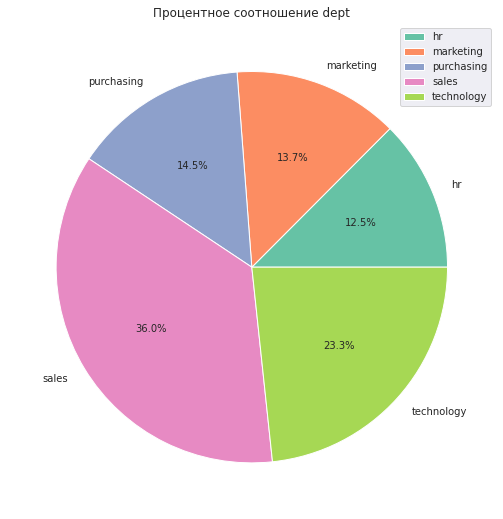

In [76]:
cat_col_analyse(
    quitted_emp.query('workload == "low"'),
    'dept',
    figsize=(9, 9)
)

Ничего необычного, всё то же самое.

Проверим, какие оценки от руководителя были у уволенных сотрудников:

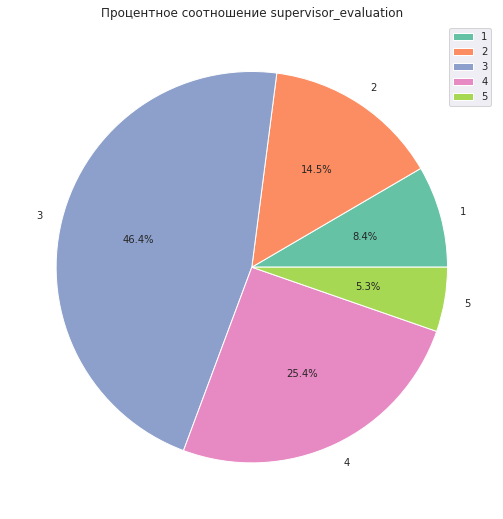

In [77]:
cat_col_analyse(
    quitted_emp,
    'supervisor_evaluation',
    figsize=(9, 9)
)

Подавляющее большинство уволившихся сотрудников получали оценку работы **3 балла** от своего руководителя. На втором месте идут **4 балла**. Посмотрим на ситуацию с повышениями:

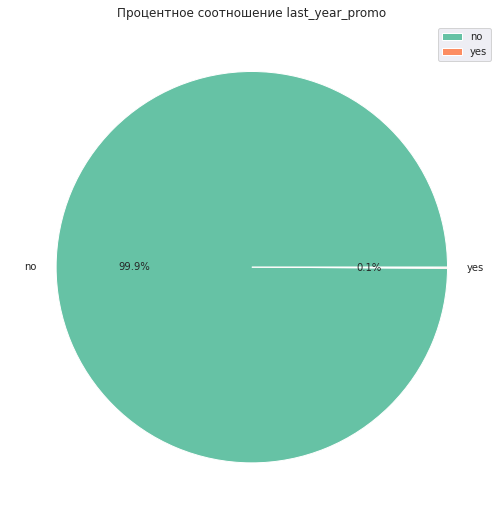

In [78]:
cat_col_analyse(
    quitted_emp,
    'last_year_promo',
    figsize=(9, 9)
)

_Практически никто не получал повышения из уволенных сотрудников._

А как обстоят дела с нарушениями ТД среди уволившихся:

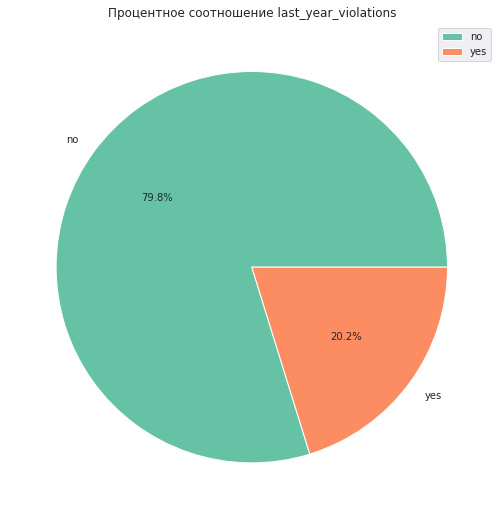

In [79]:
cat_col_analyse(
    quitted_emp,
    'last_year_violations',
    figsize=(9, 9)
)

_Из уволившихся сотрудников **20%** имели факт нарушения трудового договора._ Посмотрим стаж уволенных сотрудников:

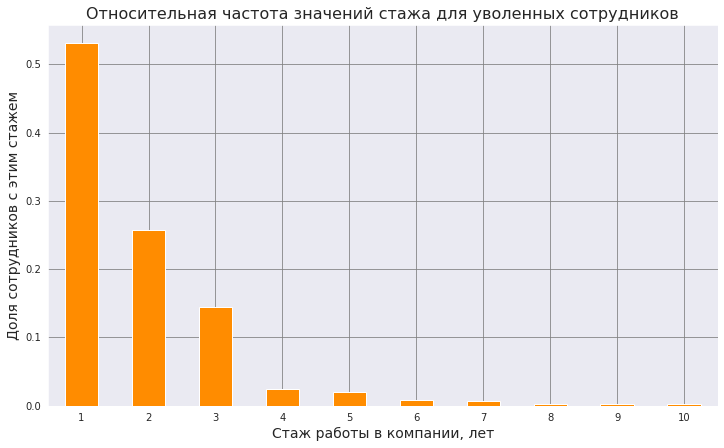

In [80]:
# Круговая диаграмма будет не совсем удобна, построим другую визуализацию:
years_proportions = quitted_emp['employment_years'].value_counts(normalize=True)
years_proportions.plot.bar(figsize=(12, 7), color='darkorange')
plt.ylabel('Доля сотрудников с этим стажем', fontsize=14)
plt.xlabel('Стаж работы в компании, лет', fontsize=14)
plt.xticks(rotation='horizontal')
plt.title('Относительная частота значений стажа для уволенных сотрудников',
         fontsize=16)

plt.show()

_Более **50%** сотрудников из группы уволившихся проработали в компании только 1 год. **25%** — два года._

Посмотрим на числовые характеристики выборки уволившихся:

In [81]:
quitted_emp.drop('id', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,1128.0,1.844858,1.274920,1.0,1.0,1.0,2.0,10.0
supervisor_evaluation,1128.0,3.046099,0.973291,1.0,3.0,3.0,4.0,5.0
salary,1128.0,23885.106383,9351.599505,12000.0,16800.0,22800.0,27600.0,79200.0


Первые выводы:
1. В среднем увольняются после **года работы**, не проработав и двух лет.
2. Увольняются и "старожилы".
3. Большинство уволившихся с зарплатой до **30 тысяч рублей**. Скорее всего, это всё джуны.

Сравним также дискретные признаки у обоих групп с помощью собственных функций по наличию/отсутствия увольнения:

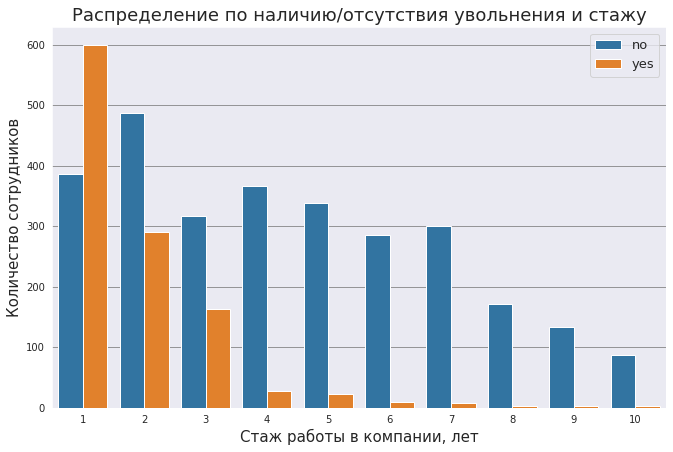

In [82]:
custom_countplot(
    train_quit,
    num_col_2[0],
    'quit',
    'по наличию/отсутствия увольнения и стажу',
    'Стаж работы в компании, лет'
)

Больше всего уволившихся сотрудников имели стаж работы в компании **1 год**. То есть, сотрудники увольняются после первого года работы. Сравним оценки руководителя у обеих групп:

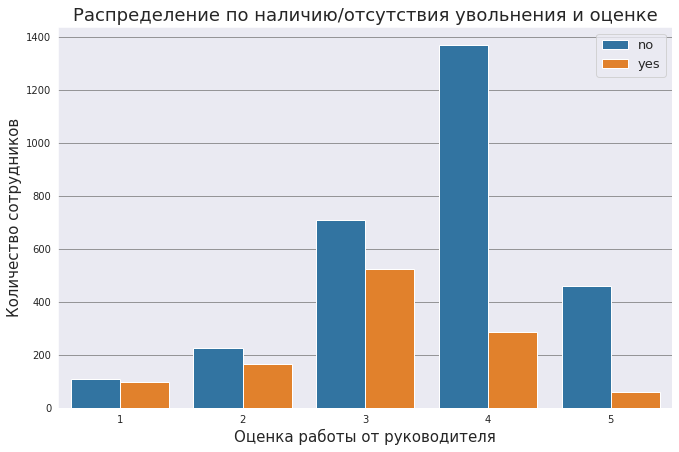

In [83]:
custom_countplot(
    train_quit,
    num_col_2[1],
    'quit',
    'по наличию/отсутствия увольнения и оценке',
    'Оценка работы от руководителя'
)

Больше всего уволившихся получали среднюю оценку работы от руководителя — 3 балла.

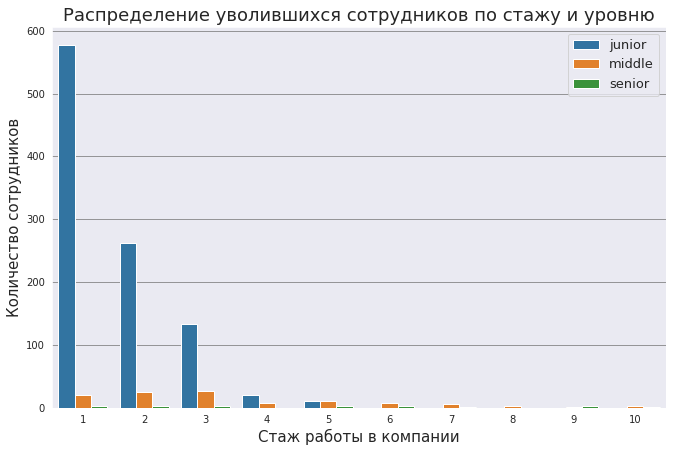

In [84]:
custom_countplot(
    quitted_emp,
    'employment_years',
    'level',
    'уволившихся сотрудников по стажу и уровню',
    'Стаж работы в компании'
)

Еще раз убеждаемся в том, что до пяти лет работы в компании чаще всего увольняются _junior_-специалисты.

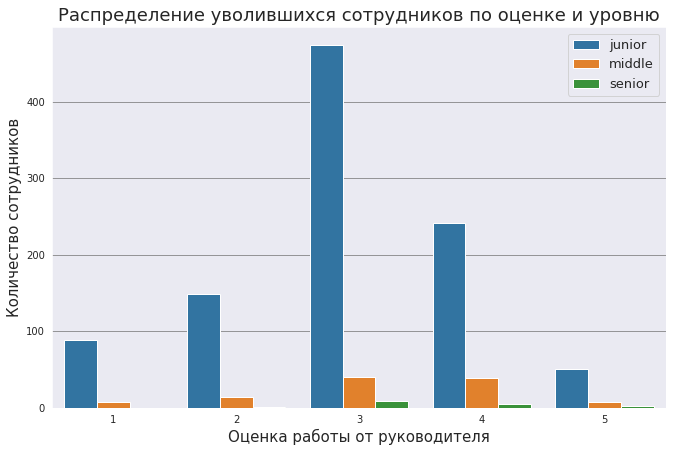

In [85]:
custom_countplot(
    quitted_emp,
    'supervisor_evaluation',
    'level',
    'уволившихся сотрудников по оценке и уровню',
    'Оценка работы от руководителя'
)

По всем оценкам снова лидируют уволившиеся джуны. Посмотрим на числовые характеристики оставшихся сотрудников.

In [86]:
remaining_emp = train_quit.query('quit == "no"')

remaining_emp.drop('id', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,2872.0,4.430710,2.544635,1.0,2.0,4.0,6.0,10.0
supervisor_evaluation,2872.0,3.643106,0.965295,1.0,3.0,4.0,4.0,5.0
salary,2872.0,37702.228412,15218.977339,12000.0,25200.0,34800.0,46800.0,96000.0


Действительно, у оставшихся зарплаты выше. Медианная з/п оставшихся **34_800р.** против **22_800р.** у уволившихся, что на 12_000р. больше. Посмотрим нагрузку у оставшихся:

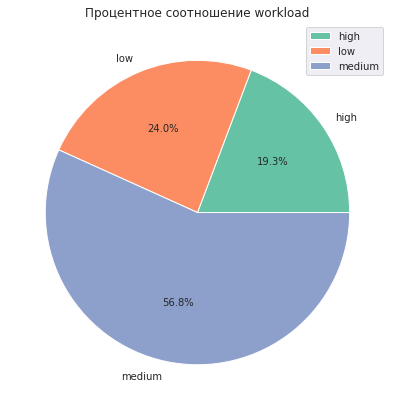

In [87]:
cat_col_analyse(
    remaining_emp,
    'workload'
)

У абсолютного большинства оставшихся сотрудников _средняя_ нагрузка. Сравним сотрудников обеих групп по уровням. Начнём с уволившихся:

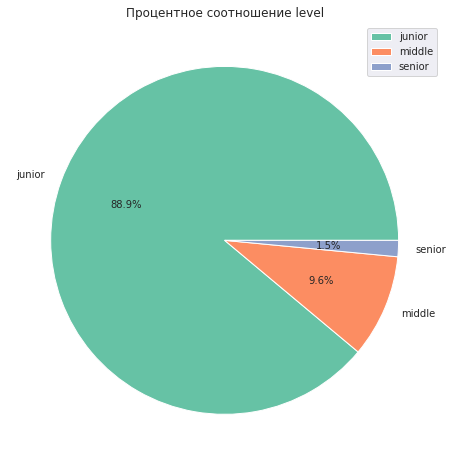

In [88]:
cat_col_analyse(
    quitted_emp,
    'level',
    figsize=(8, 8)
)

Инстересно. Уволившийся сотрудник скорее всего будет _junior-cпециалистом_. Посмотрим у них ситуацию по уровню нагрузки:

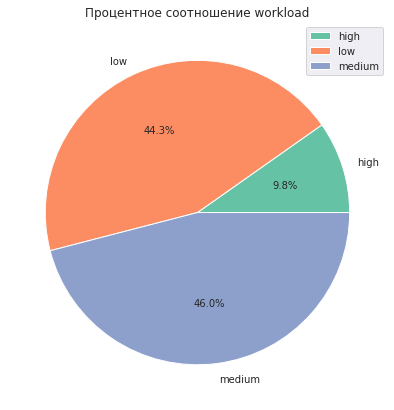

In [89]:
cat_col_analyse(
    quitted_emp.query('level == "junior"'),
    'workload'
)

Снова ничего особенного. Уровень нагрузки распределён как и в общей выборке. Сравним распределение зарплат у обоих групп.

In [90]:
# Функция построение гистограммы плотности распределений:
def custom_histplot(df, xcolumn, hue_col, xlabel, title):
    # Создание графика:
    fig, histplot = plt.subplots(figsize = (11,7))
    
    countplot = sns.histplot(
        data=df,
        x=xcolumn,
        hue=hue_col,
        bins=40,
        kde=True,
        stat='density',
        common_norm=False
    )
    
    # Настройка графика:
    histplot.set_xlabel(xlabel, fontsize=15)
    histplot.set_ylabel ('Плотность распределения', fontsize=15)
    histplot.set_title('Распределение ' + title, fontsize=18)
    #histplot.legend(loc=1, fontsize=13, labelcolor=['r', 'g'])
    
    return plt.show()

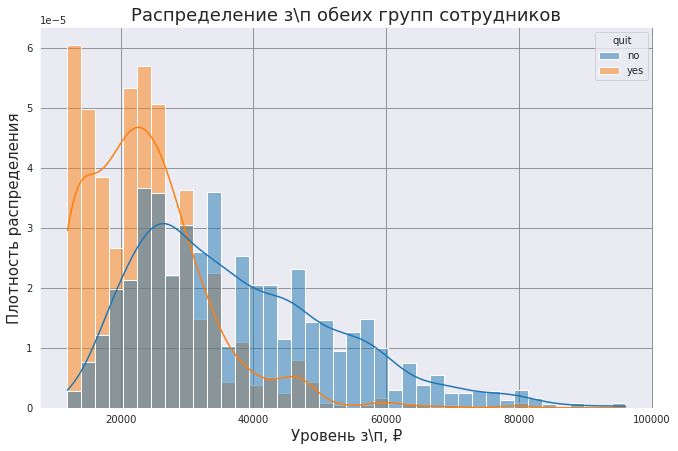

In [91]:
# Построение визуализации:
custom_histplot(
    train_quit,
    'salary',
    'quit',
    'Уровень з\п, ₽',
    'з\п обеих групп сотрудников'
)

Видим, что у уволившихся сотрудников абсолютное превосходство по плотности распределения з\п на интервале до 30 тыс. р. Это значит, что вероятность того, что случайно выбранный сотрудник с з\п из данного диапазона окажется уволившимся, будет выше.

Посмотрим еще раз на наличие повышений у уволившихся и сравним с оставшимися:

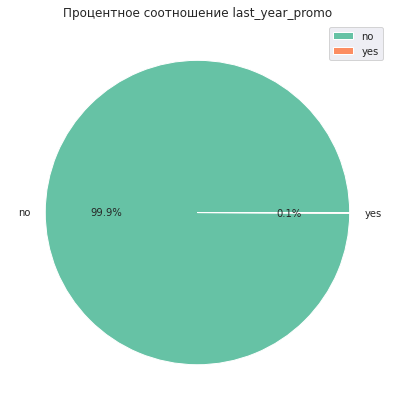

In [92]:
cat_col_analyse(
    quitted_emp,
    'last_year_promo'
)

Показательная картина. _В **99.9%** случаев уволившийся сотрудник не будет повышен за последний год._ Теперь то же самое у оставшихся:

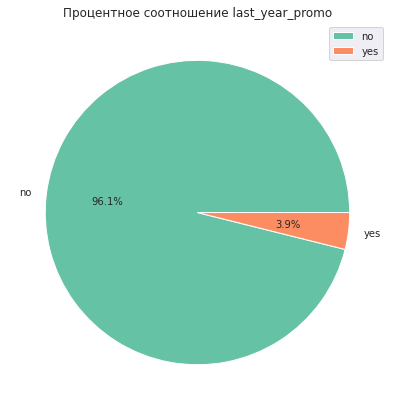

In [93]:
cat_col_analyse(
    remaining_emp,
    'last_year_promo'
)

Здесь ситуация уже лучше. Что ж, ожидаемо.

##### Итоги

_Вот примерный портрет уволившегося сотрудника_:
1. Его отдел работы — _**любой**_.
2. Его уровень — _**junior**_ с _низким_ уровнем занятости.
3. Проработавший **год**, в более редких случаях **2 года** в компании и так и _не получивший повышение_.
4. С з/п ниже **20 тысяч р.**

#### Проверка утверждения

Необходимо проверить утверждение, что **уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник**. Для этого сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

Начнём с объединения двух тестовых целевых признаков:

In [94]:
# Объединение датасетов:
common_target = test_target.merge(test_target_quit, on='id', how='left')

# Проверка:
common_target.head()

,id,job_satisfaction_rate,quit
0,485046,0.79,no
1,686555,0.72,no
2,467458,0.64,no
3,418655,0.60,no
4,789145,0.75,no


Отлично. Объединили оба признака, теперь можно построить визуализацию распределений для обоих групп.

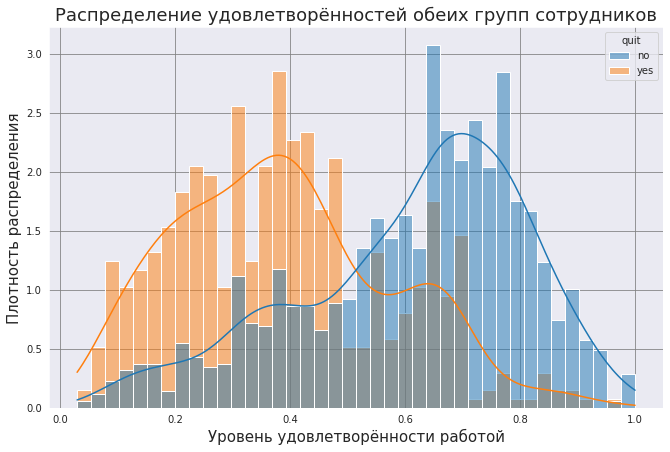

In [95]:
# Построение визуализации:
custom_histplot(
    common_target,
    target_1,
    'quit',
    'Уровень удовлетворённости работой',
    'удовлетворённостей обеих групп сотрудников'
)

##### Итоги

Действительно, из этого графика следует, что у уволившихся сотрудников уровень удовлетворённости работой гораздо _ниже_, чем у тех, кто остался в штате.

У тех, кто остался, пиковая плотность распределения оказывается на более высоком значении (**0.7**), чем у тех, кто уволился (почти **0.4**).

Следовательно, **этот показатель влияет на то, уволится ли сотрудник**.

### Добавление нового входного признака

Выше мы выяснили, что `job_satisfaction_rate` и `quit` действительно _связаны_. Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи:

In [96]:
# Проверка на пропуски:
print('\nБыло всего пропусков в test_features:',
      test_features.isna().sum().sum())

# Преобразуем в датасет:
js_pred = pd.DataFrame(y_pred, columns=['job_satisfaction_rate']).set_index(X_test.index)

# Добавим столбец для присоединения:
js_pred['id'] = test_features['id']

# Присоединение ко входным признакам:
test_features = test_features.merge(js_pred, on='id', how='left')

# Округлим новый признак:
test_features[target_1] = test_features[target_1].round(2)

# Проверка:
display(test_features.head())

# Проверка на пропуски:
print('\nСтало пропусков в test_features:',
      test_features.isna().sum().sum())


Было всего пропусков в test_features: 5


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.88
1,686555,hr,junior,medium,1,no,no,4,30000,0.68
2,467458,sales,middle,low,5,no,no,4,19200,0.70
3,418655,sales,middle,low,6,no,no,4,19200,0.70
4,789145,hr,middle,medium,5,no,no,5,40800,0.83



Стало пропусков в test_features: 5


Признак успешно добавлен в тестовые входные признаки, новых пропусков не образовано. _И раз мы сделали это в тестовые входные признаки, то нужно сделать и в тренировочные_. Можно взять из датасета `train_data`, но сперва нужно проверить соответствие `id`, чтобы не возникло пустых значений.

In [97]:
print('Кол-во совпадающих id:',
     train_data[train_data['id'].isin(train_quit['id'].unique())]['id'].count())

Кол-во совпадающих id: 0


Ничего не совпадает, и при добавлении столбца `job_satisfaction_rate` от тренировочного `train_data` из первой задачи к текущему тренировочному `train_quit`, мы образуем столбец из NaN значений. Ничего не остаётся, кроме как спрогнозировать `job_satisfaction_rate` с помощью лучшей модели из первой задачи.

В переменной `target_1` хранится строка `'job_satisfaction_rate'`.

In [98]:
# Убираем лишние признаки и получаем предсказания:
js_pred = model_reg.predict(train_quit.drop(['id', 'quit'], axis=1))

# Преобразуем в датасет:
js_pred = pd.DataFrame(
    js_pred,
    columns=[target_1]
).set_index(train_quit.drop(['id', 'quit'], axis=1).index)

# Добавим столбец для присоединения:
js_pred['id'] = train_quit['id']

# Присоединение ко входным признакам:
train_quit = train_quit.merge(js_pred, on='id', how='left')

# Округлим новый признак:
train_quit[target_1] = train_quit[target_1].round(2)

# Проверка:
display(train_quit.head())

# Проверка на пропуски:
print('\nСтало пропусков в train_quit:',
      train_quit.isna().sum().sum())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.60
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.85
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.34
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.34
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.79



Стало пропусков в train_quit: 0


#### Итоги

Таким образом, добавили признак `job_satisfaction_rate` и в тренировочные, и в тестовые входные признаки.

### Корреляционный анализ данных

С помощью написанной в первой задаче функции построим матрицу корреляции по коэфф-ту Фи. Параметру `interval_cols` передаём непрерывные числовые признаки:

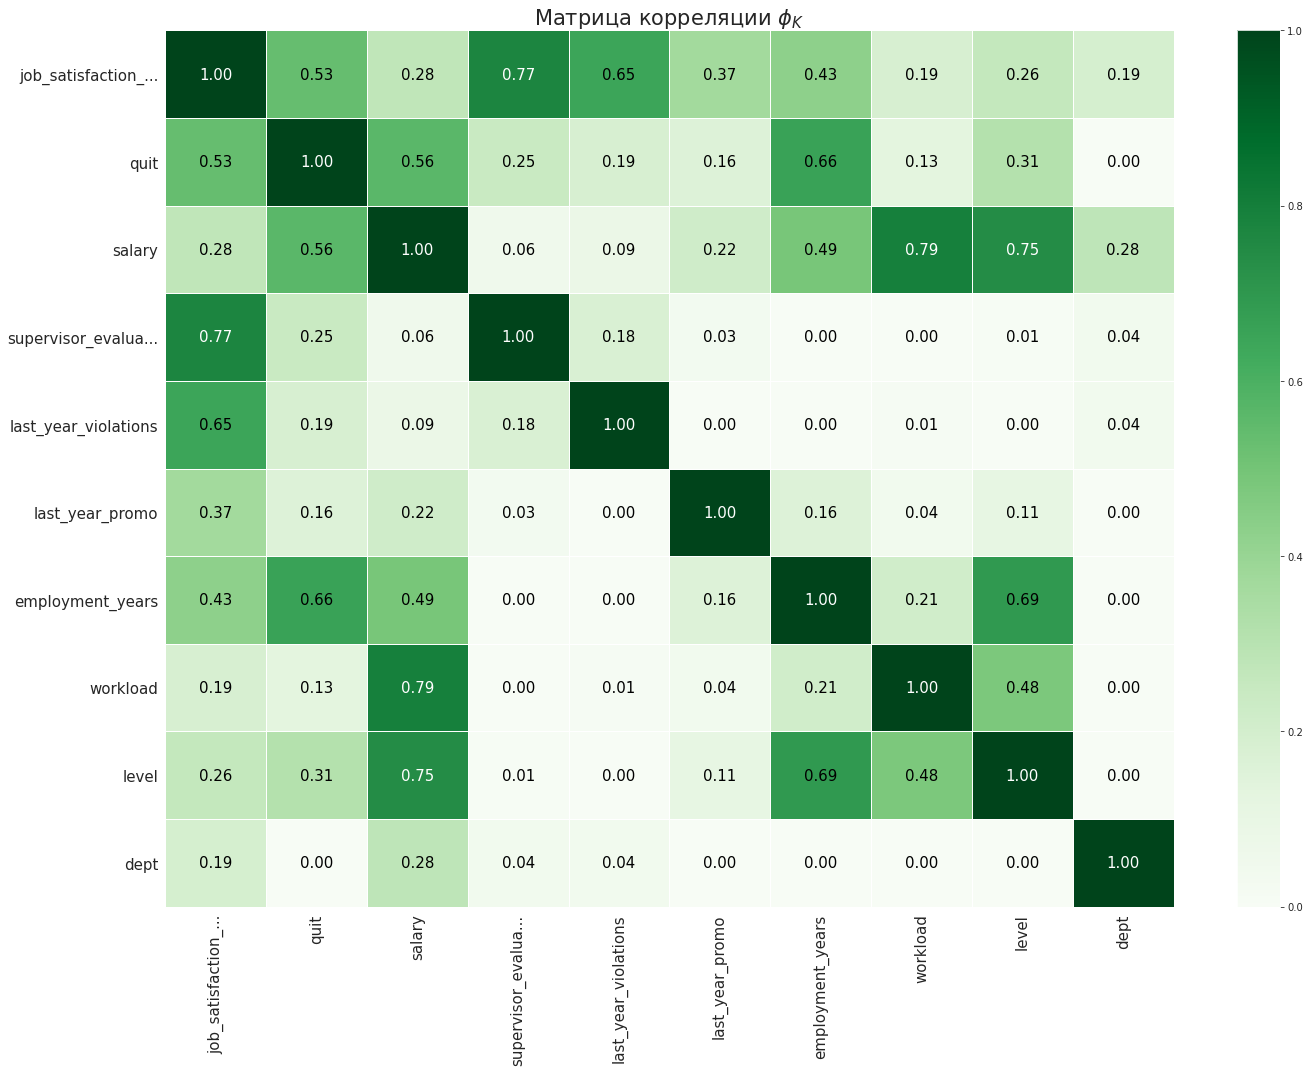

In [99]:
# Построение визуализации:
correlation_matrix(
    train_quit,
    ['salary', 'job_satisfaction_rate']
)

**Целевой признак** `quit` коррелирует со следующей степенью:
- _заметная_ связь с `employment_years`;
- _заметная_ связь с `salary`;
- _заметная_ связь с `job_satisfaction_rate`;
- _умеренная_ связь с `level`;
- с остальными связь _слабая_ или её _нет вовсе_;

Отметим, что несколько входных признаков имеют между собой _высокую_ корреляцию:
- `workload` / `salary`;
- `supervisor_evaluation` / `job_satisfaction_years`;
- `level` / `salary`;

На всякий случай построим матрицы корреляции отдельно для каждой группы, чтобы в случае чего избежать **мультиколлинеарности**.

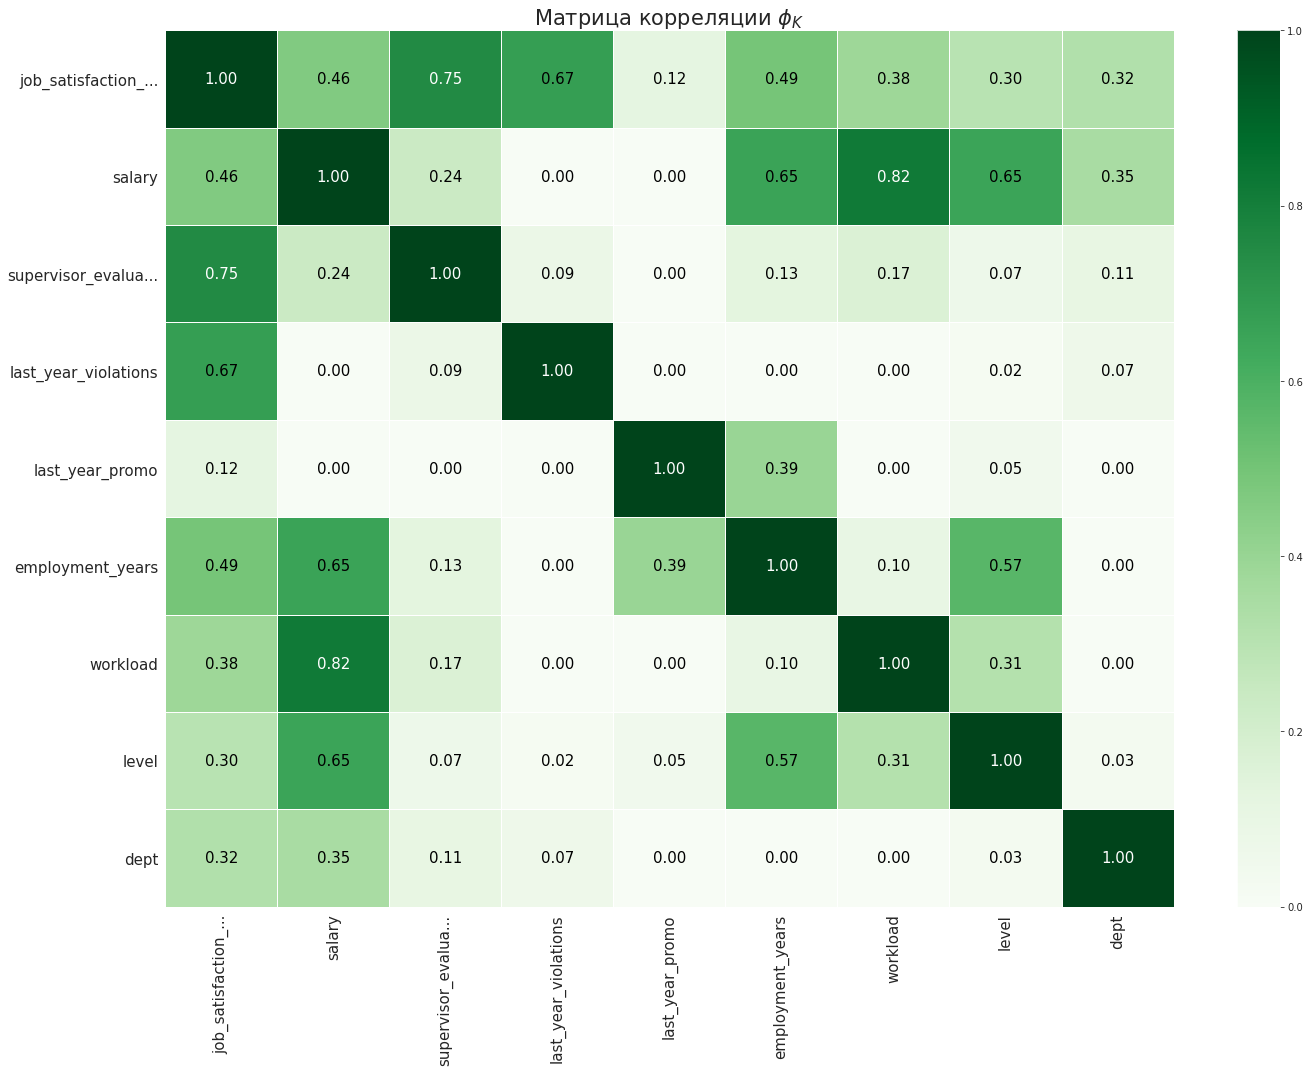

In [100]:
# МК для группы уволившихся:
correlation_matrix(
    train_quit.query('quit == "yes"'),
    ['salary', 'job_satisfaction_rate']
)

В группе уволившихся наблюдаем еще более _высокую_ корреляцию у признаков `workload` / `salary`. Однако коэффициент менее 0.9.

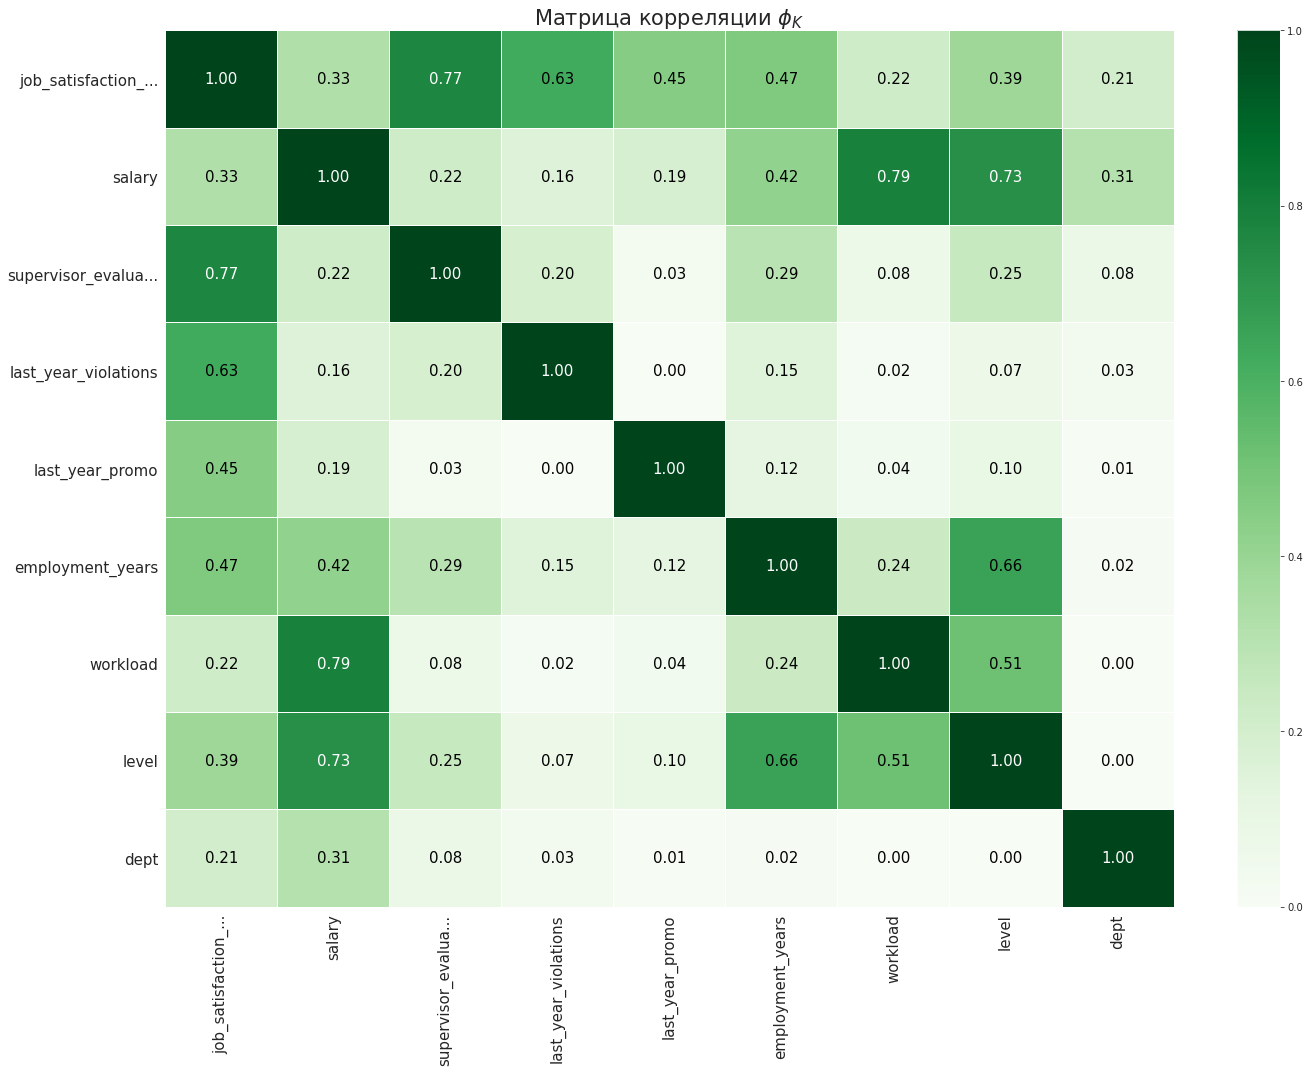

In [101]:
# МК для группы оставшихся:
correlation_matrix(
     train_quit.query('quit == "no"'),
    ['salary', 'job_satisfaction_rate']
)

Для группы оставшихся не наблюдаем корреляцию у входных признаков более _высокую_, чем **0.79** — `workload` / `salary`.

#### Итоги


_**Мультиколлинеарности не наблюдается**_.


### Подготовка данных

Как и в предыдущей задаче, признаки будем кодировать:


1. Эти признаки закодируем с помощью _OrdinalEncoder_: `level`, `workload`. Они являются _ранговыми категориями_.


2. Эти признаки закодируем с помощью _OneHotEncoder_: `dept`, `last_year_promo`, `last_year_violations`. Параметру `drop` так же передадим значение _first_, чтобы избежать избыточных переменных.


3. Эти признаки (количественные) будем _масштабировать_: `salary`, `job_satisfaction_rate`.


4. Пропущенные значения будем обрабатывать с помощью _SimpleImputer_.


5. **Целевой признак закодируем с помощью _LabelEncoder_.**

Сохраним их отдельно по типам обработки:

In [102]:
# Обозначим целевой признак:
target_2 = 'quit'

# Разделим признаки по способам кодирования:
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']

ord_col = ['level', 'workload']

num_col = ['salary', 'job_satisfaction_rate']

Перед обозначением выборок нужно по аналогии с предыдущей задачей убрать явные дубликаты в тренировочных данных без участия `id` для повышения качества обучения модели.

In [103]:
# Перенос id объектов в индексы:
train_quit = train_quit.set_index('id')

# Проверка на явные дубликаты:
print('Кол-во явных дубликатов без id:', train_quit.duplicated().sum())

Кол-во явных дубликатов без id: 1413


Многовато, но что поделать. Уберём явные дубликаты:

In [104]:
# Удаление явных дубликатов:
train_quit.drop_duplicates(inplace=True)

# Проверка:
print(f'Теперь в тренировочных данных {train_quit.shape[0]} строк.')

# Восстановим индексацию:
train_quit['id'] = train_quit.index
train_quit.reset_index(drop=True, inplace=True)

# Проверка:
train_quit.head()

Теперь в тренировочных данных 2587 строк.


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate,id
0,sales,middle,high,2,no,no,4,54000,no,0.60,723290
1,sales,junior,medium,2,no,no,4,27600,no,0.85,814010
2,purchasing,middle,medium,5,no,no,1,37200,no,0.34,155091
3,sales,junior,medium,2,no,yes,3,24000,yes,0.34,257132
4,marketing,junior,medium,2,no,no,5,25200,no,0.79,910140


Теперь можно обозначить выборки:

In [105]:
# Обозначение выборок:
X_train = train_quit.drop(['id', target_2], axis=1)
y_train = train_quit[target_2]

X_test = test_features.drop('id', axis=1)
y_test = test_target_quit[target_2]

# Проверка размерностей:
print('Размерность X_train:', X_train.shape)
print('Размерность y_train:', y_train.shape)
print('\nРазмерность X_test:', X_test.shape)
print('Размерность y_test:', y_test.shape)

Размерность X_train: (2587, 9)
Размерность y_train: (2587,)

Размерность X_test: (2000, 9)
Размерность y_test: (2000,)


Получили новые тренировочные и тестовые выборки.

Перед нами стоит задача **бинарной классификации**, поэтому будем использовать две модели для решения такой задачи: 
- _`DecisionTreeClassifier`_ (дерево решений);
- _`KNeighborsClassifier`_ (kNN);
- _`SVC`_ (Support Vector Classification);

Для каждой определим дипазоны гиперпараметров и будем перебирать с помощью _RandomizedSearchCV_. Метрикой для качества модели выступит **ROC_AUC**.

Пайплайн `data_preprocessor` с подготовкой данных уже написан, поэтому изменим только итоговый пайплайн:

In [106]:
# Создаём новый итоговый пайплайн:
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Так же закодируем целевой признак с помощью _LabelEncoder_:

In [107]:
# Инициализация инструмента:
label_encoder = LabelEncoder()

# Обучение кодировщика и кодирование трен. признака:
y_train = label_encoder.fit_transform(y_train)

# Кодирование тестового целевого признака:
y_test = label_encoder.transform(y_test)

# Вывод результатов кодирования:
print('Теперь класс 0:', label_encoder.classes_[0])
print('Теперь класс 1:', label_encoder.classes_[1])

Теперь класс 0: no
Теперь класс 1: yes


Таким образом, мы получили новые метки классов целевого признака.

Теперь создадим словарь (список словарей) гиперпараметров (ГП):

In [108]:
param_rs = [
    
    # Словарь для модели DecisionTreeClassifier:
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        
        'models__max_depth': range(1, 26),
        'models__min_samples_split': range(2, 16),
        'models__min_samples_leaf': range(1, 16),
     
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
     
    
    # Словарь для модели kNN:
    {
        'models': [KNeighborsClassifier(n_jobs=-1)],
        
        'models__n_neighbors': range(1, 16),
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    
    # Словарь для модели SVC:
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        
        'models__kernel': ['linear', 'poly'],
        'models__C': np.arange(0.01, 1.1, 0.1),
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }

]

#### Получение лучшей модели

Передаём список инструменту _RandomizedSearchCV_:

In [109]:
rs_task_2 = RandomizedSearchCV(
    pipe_final_2,
    param_rs,
    scoring='roc_auc',
    n_jobs=-1,
    cv=20,
    n_iter=50,
    random_state=RANDOM_STATE
)

# Запуск подбора:
rs_task_2.fit(X_train, y_train)

# Вывод результатов:
print('Лучшая модель и её параметры:\n\n', rs_task_2.best_params_)
print('\n\nМетрика ROC-AUC лучшей модели на кросс-валидации:',
      rs_task_2.best_score_.round(2))

Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'models__min_samples_split': 15, 'models__min_samples_leaf': 13, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}


Метрика ROC-AUC лучшей модели на кросс-валидации: 0.9


Лучшей моделью оказалась **DecisionTreeClassifier** со следующими ГП:

- _Макс. глубиной_ (уровнями с лог. условиями) `4`;
- _Кол-вом объектов в одном листе_ `13`;
- _Кол-вом объектов в листе для разделения на классы_ `15`;
- С  масштабированием указанных числовых признаков с помощью _StandardScaler_;

Проверим эту модель. Модель будет успешной при значении метрики **ROC-AUC ≥ 0.91** на тестовой выборке.

In [110]:
# Выделим лучшую модель:
model_clf = rs_task_2.best_estimator_

# Получение предсказаний увольнения, или класса 1:
y_prob_quit = model_clf.predict_proba(X_test)[:, 1]

# Вывод результата:
print('Метрика ROC-AUC лучшей модели на тестовой выборке:',
      round(roc_auc_score(y_test, y_prob_quit), 2))

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.91


Отлично. Модель оказалась успешной со значением метрики ROC-AUC **0.91**. Проверим её на адекватность.

#### Проверка на адекватность

Инициализируем дамми-модель, получим от неё предсказания и сравним метрики:

In [111]:
# Инициализация модели:
dummy_clf = DummyClassifier(random_state=RANDOM_STATE)

# Обучение дамми-модели:
dummy_clf.fit(X_train, y_train)

# Получение от неё предсказаний класса 1:
dummy_clf_pred = dummy_clf.predict_proba(X_test)[:, 1]

# Получение метрики:
print('Метрика ROC-AUC дамми-модели на тестовой выборке:',
      round(roc_auc_score(y_test, dummy_clf_pred), 2))

Метрика ROC-AUC дамми-модели на тестовой выборке: 0.5


Колоссальная разница. Проверка на адекватность пройдена.

### Оформление выводов

Осталось показать, на что ориентировалась лучшая модель при расчёте предсказанных значений и что сильнее влияло на это. Для этого воспользуемся уже знакомым методом **SHAP**:

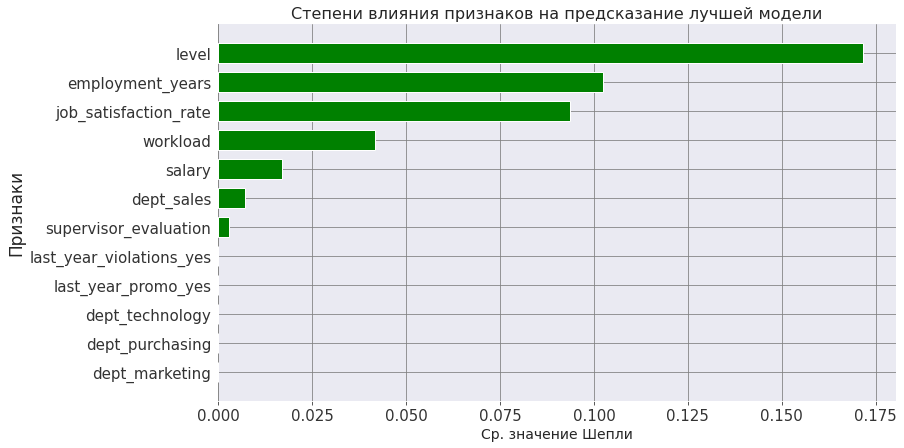

In [112]:
# Извлекаем из этапа пайплайна способы подготовки данных:
preprocessor = model_clf.named_steps['preprocessor']


# Преобразование признаков трен. выборки:
X_train_transformed = preprocessor.fit_transform(X_train)


# Объявление эксплейнера:
explainer = shap.TreeExplainer(model_clf.named_steps['models'], X_train_transformed)


# Преобразование признаков тест. выборки:
X_test_transformed = preprocessor.transform(X_test)

# Получим названия признаков:
feature_names = preprocessor.get_feature_names_out()

# Формируем преобразованный тестовый датафрейм:
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)


# Объявляем shap_values:
shap_values = explainer(X_test_transformed)


# Уберём префиксы в именах признаков:
feature_names = [name.split("__")[-1] for name in feature_names]

# Построение графика важности признаков:
shap.summary_plot(
    shap_values[:, :, 1],
    X_test_transformed,
    plot_type='bar',
    feature_names=feature_names,
    plot_size=[12,6],
    color='g',
    show=False
)

# Настройка графика:
fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=10)
ax.set_xlabel('Ср. значение Шепли', fontsize=14)
ax.set_title(
    'Степени влияния признаков на предсказание лучшей модели',
    fontsize=16
)

cb_ax = fig.axes[0] 

cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Признаки", fontsize=17)

plt.show()

Видим, что самое сильное влияния на предсказания оказывает **3 признака**:

1. Уровень специалиста `level`;
2. Длительность работы в компании `employment_years`;
3. Удовлетворённость работой в компании `job_satisfaction_rate`;

Рассмотрим подробнее влияние значений признаков:

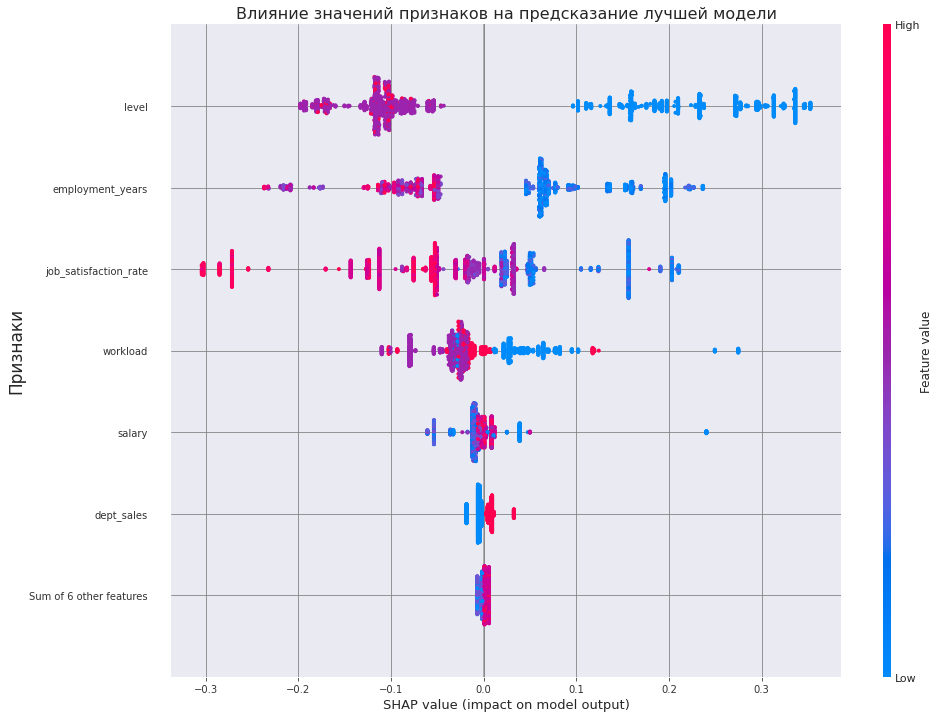

In [113]:
# Создание нового объекта Explanation с feature_names:
shap_explanation_2 = shap.Explanation(
    values=shap_values.values[:, :, 1],
    base_values=shap_values.base_values,
    data=X_test_transformed,
    feature_names=feature_names
)

# Построение графика:
shap.plots.beeswarm(
    shap_explanation_2,
    max_display=7,
    plot_size=(15, 12),
    show=False
)

# Настройка графика:
fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_title(
    'Влияние значений признаков на предсказание лучшей модели',
    fontsize=16
)

cb_ax = fig.axes[0] 

cb_ax.tick_params(labelsize=10)
cb_ax.set_ylabel('Признаки', fontsize=17)

plt.show()

Слева от вертикальной черты класс 0, справа — класс 1.

1. Значение признака `level` равное 0 (закодированный _junior_) всегда увеличивает вероятность принадлежности объекта к _классу `1`_ (уволился).


2. Чем _больше_ значение признака `employment_years`, тем _больше_ вероятность того, что объект будет относиться к _классу `0`_ (не уволился).


3. Чем _выше_ значение признака `job_satisfaction_rate`, тем _больше_ вероятность того, что объект будет относиться к _классу `0`_ (не уволился).


4. Значение признака `workload` равное 0 (синий цвет, закодированная _низкая нагрузка_), увеличивает вероятность принадлежности объекта к _классу `1`_ (уволился).

## Общий вывод

Перед нами стояло две задачи:

1. **Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.**


2. **Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.**

Для решения **обеих** задач были проделаны следующие этапы:

1. Исходные тренировочные и тестовые данные представляли собой 3 датасета с входными признаками для объектов. С ними было проведено ознакомление и проверка соответствия их описанию.



2. В процессе предобработки данных мы избавились от некорректных значений.



3. Далее был исследовательский анализ, на котором мы выяснили основные моменты:
     
  - Больше всего сотрудников имеет степень удовлетворённости **от 0.61 до 0.7**.
  
  - Больше всего в компании задействовано _junior_-специалистов (**47.4%**).
  
  - Большинство сотрудников из выборки работает в _отделе продаж_ (**37.9%**).
  
  - **Только 3% сотрудников получили повышение за последний год.**
  
  - **14%** сотрудников из предоставленной выборки нарушали трудовой договор за последний год.
  


4. Так же был был построен портрет «уволившегося сотрудника»:
    - Отдел работы — _**любой**_.
    - Его уровень — _**junior**_ с _низким_ уровнем занятости.
    - Проработавший год или больше и так и _не получивший повышение_.
    - С з/п ниже **20 тысяч р.**
    


5. Так же было проверено утверждение от аналитиков, что **уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник**. _Ответ_: **да, это действительно так.**



6. Мультиколлинеарности в данных не было обнаружено.



7. **Лучшая модель для задачи №1, регрессии:** _DecisionTreeRegressor_ со значением метрики **SMAPE** 13.5 на тесте.

    - Чем _ниже_ значение признака `оценки от руководителя`, тем выше вероятность, что **удовлетворённость** будет _занижена_. Этот показатель влияет сильнее всего.



8. **Лучшая модель для задачи №2, бин. классификации:** _DecisionTreeClassifier_ со значением метрики **ROC-AUC** 0.91 на тесте.
    - самое сильное влияния на предсказания оказывает **3 признака**:
    
    
    - 1. Удовлетворённость работой в компании job_satisfaction_rate;
    - 2. Длительность работы в компании employment_years;
    - 3. Уровень специалиста level;
    
    
   - Значение признака `level` равное 0 (закодированный _junior_), всегда увеличивает вероятность принадлежности объекта к _классу `1`_ (уволился).
   
   
   - Чем _выше_ значение признака `employment_years`, тем _больше_ вероятность того, что объект будет относиться к _классу `0`_ (не уволился).
   
   - Чем _выше_ значение признака `job_satisfaction_rate`, тем _больше_ вероятность того, что объект будет относиться к _классу `0`_ (не уволился).
   
   
   
**Дополнительные предложения для бизнеса:**

1. _Скорректировать обратную связь_ от руководителей к своим сотрудникам. От _качества_ и _формы_ этой обратной связи будет зависеть удовлетворённость сотрудника работой в компании.


2. _Повысить_ мотивацию сотрудников через **повышение** в должности минимум раз в год, либо через **повышение заработной платы**.


3. _Не создавать_ профицит junior-специалистов, которые в итоге будут находиться с низкой загруженностью в штате и с низкой заработной платой. Такие сотрудники не видят продвижения, следовательно, у них падает мотивация и они увольняются.